In [1]:
%load_ext autoreload
%autoreload 2

# Init memories

In [4]:
import os

from cama.memory import WorkingMemory, EpisodicMemory, SemanticMemory
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import json

from docarray import BaseDoc, DocList
from typing import Tuple, List
from rich import print

# dataset_folder = "datasets/financial"
# dataset_folder = "datasets/healthcare"
dataset_folder = "datasets/eligibility"

df_reference = pd.read_csv(f"{dataset_folder}/initial.csv")
df_current = pd.read_csv(f"{dataset_folder}/drifted.csv")

with open(f'{dataset_folder}/dataset_description.json', 'r') as f:
    dataset_description = json.load(f)

# Split initial dataset into training and testing sets
label_name = dataset_description["LABEL"]
X_reference = df_reference.drop(columns=[label_name])
y_reference = df_reference[label_name]
X_train_reference, X_test_reference, y_train_reference, y_test_reference = train_test_split(X_reference, y_reference, test_size=0.2, random_state=42)

# Split drifted dataset into training and testing sets
X_current = df_current.drop(columns=[label_name])
y_current = df_current[label_name]
X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(X_current, y_current, test_size=0.2, random_state=42)

X_train_reference.head()

,Age,Income,Education Level,Employment Status,Marital Status
29,39,51755.0,2,1,0
535,51,39430.0,2,2,1
695,47,37106.0,2,1,1
557,47,37106.0,1,1,1
836,43,33641.0,2,1,1


In [5]:
from sklearn.ensemble import RandomForestClassifier

model_reference = RandomForestClassifier(random_state=42)
model_reference.fit(X_train_reference, y_train_reference)

# Test the model on the initial test set
initial_accuracy = model_reference.score(X_test_reference, y_test_reference)
print(f'Model trained and evaluated on the reference distribution: {initial_accuracy}')

Model trained and evaluated on the reference distribution: 0.775

## Episodic memory

In [6]:
from cama.memory import CurrentDataset


current_dataset = CurrentDataset(X=X_test_current, y_current=None, description=dataset_description)
first_episodic_memory = EpisodicMemory(current_dataset=current_dataset, task=0)
init_episodic_memory = DocList[EpisodicMemory]([first_episodic_memory])
# episodic_memory[0]


## Semantic memory

In [7]:
from cama.tools import get_tools
from cama.tools import get_drift_report, get_shap_values
from cama.memory import ReferenceDataset


tools = get_tools([get_drift_report, get_shap_values])


# At the beginning, the agent has 1 entry in the semantic memory. 
reference_dataset = ReferenceDataset(X_train=X_train_reference, 
                                     X_test=X_test_reference, 
                                     y_train=y_train_reference, 
                                     y_test=y_test_reference, 
                                     description=dataset_description)

init_semantic_memory = SemanticMemory(reference_dataset=reference_dataset, 
                                 tools=tools, model=model_reference)
# semantic_memory

## Dataset representation

In [8]:
from cama.representation import get_dataset_representation

get_drift_report_function = init_semantic_memory.tools['get_drift_report'].function
get_shap_values_report_function = init_semantic_memory.tools['get_shap_values'].function

drift_report = get_drift_report_function(init_semantic_memory.reference_dataset.description,
                                         init_semantic_memory.reference_dataset.X_train,
                                         init_episodic_memory[0].current_dataset.X,
                                         drift_share=0.7,
                                         show_plot=False)['drift_by_columns']

shap_report_train_reference = get_shap_values_report_function(init_semantic_memory.model,
                                                                init_semantic_memory.reference_dataset.X_train,
                                                                init_semantic_memory.reference_dataset.description)
shap_report_test_current = get_shap_values_report_function(init_semantic_memory.model,
                                                            init_episodic_memory[0].current_dataset.X,
                                                            init_episodic_memory[0].current_dataset.description)

shap_report = {feature: {'reference': shap_report_train_reference[feature], 'current': shap_report_test_current[feature]} for feature in shap_report_train_reference}
tools_results = {'get_drift_report': drift_report, 'get_shap_values': shap_report}


dataset_representation = get_dataset_representation(init_semantic_memory, tools_results)
# dataset_representation

# Generate/Load ground truth report

In [9]:
from cama.utils import get_ground_truth_template, generate_ground_truth_prompt

gt_template = get_ground_truth_template(init_semantic_memory,
                                        init_episodic_memory, 
                                        dataset_representation)
gt_prompt = generate_ground_truth_prompt(gt_template)
print(gt_prompt.format())

System: 
    You are an expert in data science and machine learning. Read the following report and complete it by filling 
inside the text '(Here the LLM should provide...)' with your explanations. Keep all the remaining text as it is.


# Comprehensive Report

## Executive Summary

(Here the LLM should provide an executive summary of the report.)

## Dataset Synopsis
**Title**: Eligibility Simulation Data  
**Features Analyzed**: Age, Income, Education Level, Employment Status, Marital Status
**Label Variable**: ProgramEligibility  

This dataset simulates the eligibility of individuals for a specific program, focusing on attributes such as Age, 
Income, Education Level, Employment Status, and Marital Status. The 'ProgramEligibility' variable serves as the 
label, indicating whether an individual is eligible (1) or not eligible (0) for the program. 


## Label Description
**ProgramEligibility**: Indicates eligibility for a specific program, with 0 representing not eligible and 1 
representing eligible, serving as the label variable for predictions.
(Here the LLM should provide an explanation if the label has issues or not. Remember that the label was not used in
the drift analysis and SHAP values.)

## Feature Analysis

### Feature name: Age
- **Description**: Age of the individual in years, ranging from 18 to 65.
- **Type**: Numerical
- **Possible Values**: Ranging from 18 to 65 years.
- **Data Type**: int

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.06325575780482698
- **Detection**: No drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [24.0, 27.4, 30.8, 34.2, 37.6, 41.0, 44.4, 47.8, 51.2, 
54.599999999999994, 58.0], 'y': [0.010294117647058827, 0.0264705882352941, 0.03970588235294115, 
0.038235294117647076, 0.039705882352941195, 0.06911764705882356, 0.027941176470588247, 0.02499999999999996, 
0.01029411764705885, 0.007352941176470575]}}
  - Reference: {'small_distribution': {'x': [18.0, 22.7, 27.4, 32.1, 36.8, 41.5, 46.2, 50.9, 55.6, 
60.300000000000004, 65.0], 'y': [0.0007978723404255321, 0.0053191489361702135, 0.02313829787234041, 
0.03085106382978726, 0.05265957446808508, 0.04893617021276593, 0.025265957446808533, 0.018351063829787222, 
0.005851063829787231, 0.0015957446808510653]}}
  - Interpretation: (Here the LLM should provide an interpretation of the current vs reference distribution. Gives 
examples of the differences.)

#### Feature Attribution Analysis
  - Method: Tree SHAP
  - Training Data: 0.1675692700443467 (Rank 2)
  - Current Data: 0.10098040394127042 (Rank 2)
  - Interpretation: (Here the LLM should provide an interpretation of the current vs reference SHAP values.)

#### Overal Interpretation**: 
  (Here the LLM should provide an overall interpretation for the feature: Age.)

### Feature name: Income
- **Description**: Annual income of the individual in thousands of dollars, indicating economic status, ranging 
from 20k to 70k.
- **Type**: Numerical
- **Possible Values**: Ranging from $20,000 to $70,000.
- **Data Type**: float

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.7978008461594442
- **Detection**: Drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [-3508.2364074368093, 10667.570547951202, 24843.377503339212, 
39019.18445872722, 53194.99141411523, 67370.79836950325, 81546.60532489125, 95722.41228027927, 109898.21923566727, 
124074.02619105528, 138249.8331464433], 'y': [1.4108544270489167e-06, 4.5852768879089795e-06, 
8.465126562293502e-06, 1.6577539517824768e-05, 1.8693821158398144e-05, 1.022869459610465e-05, 
5.643417708195664e-06, 2.468995247335605e-06, 1.7635680338111466e-06, 7.05427213524458e-07]}}
  - Reference: {'small_distribution': {'x': [21687.0, 26395.8, 31104.6, 35813.4, 40522.2, 45231.0, 49939.8, 
54648.6, 59357.4, 64066.200000000004, 68775.0], 'y': [2.389143730886851e-0

In [10]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from cama.utils import generate_ground_truth_prompt
from cama.utils import extract_markdown
from cama.utils import save_to_file
from cama.utils import load_from_file

load_dotenv('env')

openai_llm = ChatOpenAI(temperature=0.7, model_name="gpt-4o", cache=False)
 
gt_prompt = generate_ground_truth_prompt(gt_template)

# dataset_folder = "eligibility_dataset"
file_name = 'gt_report.md'
# Save to file if it doesn't exist
file_path = f'{dataset_folder}/{file_name}'

if os.path.exists(file_path):
    print(f"{file_path} already exists. Loading from file.")
    gt_report = load_from_file(file_path)
else: 
    print(f"Invoking the pipeline to generate the ground truth report.")
    chain = gt_prompt | openai_llm | extract_markdown
    gt_report = chain.invoke({})#.content
    print(f"Saving the ground truth report to {file_path}")
    save_to_file(gt_report, file_path)

# print(gt_report)


datasets/eligibility/gt_report.md already exists. Loading from file.

# Generate/Load queries and answers

In [11]:
from cama.utils import generate_mchoice_qa_prompt, extract_json

number_qa = 40
qa_prompt = generate_mchoice_qa_prompt(gt_report, number_qa)
print(qa_prompt.format())

System: You are an expert in data science.
Human: 
    Generate 40 detailed multiple-choice questions and concise answers based on the following comprehensive report.
    Each question should have five options (A, B, C, D, E) and should cover various aspects of the report. Ensure 
the correct answer is clearly indicated and is unique. 
    Make sure to include numerical comparisons and insights drawn from the current and reference distributions 
wherever applicable:


    # Comprehensive Report

## Executive Summary

This report analyzes the eligibility simulation data to determine how different features such as Age, Income, 
Education Level, Employment Status, and Marital Status affect the ProgramEligibility. By utilizing distribution 
drift analysis and SHAP values, we aim to identify changes in the data distribution and the significance of each 
feature in predicting eligibility.

## Dataset Synopsis
**Title**: Eligibility Simulation Data  
**Features Analyzed**: Age, Income, Education Level, Employment Status, Marital Status
**Label Variable**: ProgramEligibility  

This dataset simulates the eligibility of individuals for a specific program, focusing on attributes such as Age, 
Income, Education Level, Employment Status, and Marital Status. The 'ProgramEligibility' variable serves as the 
label, indicating whether an individual is eligible (1) or not eligible (0) for the program. 

## Label Description
**ProgramEligibility**: Indicates eligibility for a specific program, with 0 representing not eligible and 1 
representing eligible, serving as the label variable for predictions.

The label does not exhibit issues in this analysis. However, it is important to note that the label was not 
included in the drift analysis and SHAP values, focusing solely on feature behavior and influence.

## Feature Analysis

### Feature name: Age
- **Description**: Age of the individual in years, ranging from 18 to 65.
- **Type**: Numerical
- **Possible Values**: Ranging from 18 to 65 years.
- **Data Type**: int

#### Distribution Drift Analysis
- **Statistical Test**: Kullback-Leibler divergence
- **Drift Score**: 0.06325575780482698
- **Detection**: No drift detected
- **Current vs. Reference Distribution**:
  - Current: {'small_distribution': {'x': [24.0, 27.4, 30.8, 34.2, 37.6, 41.0, 44.4, 47.8, 51.2, 
54.599999999999994, 58.0], 'y': [0.010294117647058827, 0.0264705882352941, 0.03970588235294115, 
0.038235294117647076, 0.039705882352941195, 0.06911764705882356, 0.027941176470588247, 0.02499999999999996, 
0.01029411764705885, 0.007352941176470575]}}
  - Reference: {'small_distribution': {'x': [18.0, 22.7, 27.4, 32.1, 36.8, 41.5, 46.2, 50.9, 55.6, 
60.300000000000004, 65.0], 'y': [0.0007978723404255321, 0.0053191489361702135, 0.02313829787234041, 
0.03085106382978726, 0.05265957446808508, 0.04893617021276593, 0.025265957446808533, 0.018351063829787222, 
0.005851063829787231, 0.0015957446808510653]}}
  - Interpretation: The current distribution shows higher frequencies in the middle age ranges (30-50 years) 
compared to the reference distribution, which has a more even spread across the age range. This suggests a slight 
shift in the population's age composition, although no significant drift is detected.

#### Feature Attribution Analysis
  - Method: Tree SHAP
  - Training Data: 0.1675692700443467 (Rank 2)
  - Current Data: 0.10098040394127042 (Rank 2)
  - Interpretation: The SHAP values indicate that Age is consistently the second most important feature in 
predicting program eligibility. However, its importance has slightly decreased in the current data compared to the 
training data.

#### Overall Interpretation**: 
  Age remains a crucial factor in determining program eligibility, with no significant distribution drift detected.
The slight decrease in SHAP value suggests a minor reduction in its predictive power in the current data.

### Feature name: Income
- **Description**: Annual income of the individual in thousands of dollars, in

In [12]:
from cama.utils import save_json_to_file, load_from_json

# chain = qa_prompt | openai_llm | extract_json

file_path = f'{dataset_folder}/qa_list.json'
if os.path.exists(file_path):
    print(f"{file_path} already exists. Loading from file.")
    qa_list = load_from_json(file_path)
else:
    print(f"Invoking the pipeline to generate the QA list.")
    chain = qa_prompt | openai_llm | extract_json
    qa_list = chain.invoke({})
    print(f"Saving the QA list to {file_path}")
    save_json_to_file(qa_list, file_path)

len(qa_list)

datasets/eligibility/qa_list.json already exists. Loading from file.

datasets/eligibility/qa_list.json object loaded successfully

39

## CAMA report/answers

In [13]:
from cama.decision import DecisionProcedure
from langchain_community.chat_models import ChatOllama
from langchain_community.llms import Ollama
from langchain_groq import ChatGroq
from cama.utils import print_function_name
from dotenv import load_dotenv


load_dotenv('env')
llm_name = "llama3-8b-8192"
# llm_name = "llama3-70b-8192"
# llm_name = "mixtral-8x7b-32768"
# llm_name = "gemma-7b-it"

# llm_name = "phi3:14b"
# llm_name = "phi3"

llm_generator = ChatGroq(cache=False, temperature=0.0, model_name=llm_name)
# llm_generator = ChatOllama(model=llm_name, cache=False, temperature=0.0)  #
llm_generator

ChatGroq(cache=False, client=<groq.resources.chat.completions.Completions object at 0x7effe8d45550>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7effe8d46810>, model_name='llama3-8b-8192', temperature=1e-08, groq_api_key=SecretStr('**********'))

In [14]:
from cama.utils import save_to_file

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Monitoring"

# eligibilit threshold = 0.70
# healthcare threshold = 0.65
# finance threshold = 0.35

working_memory = WorkingMemory(episodic_memory=init_episodic_memory, 
                              semantic_memory=init_semantic_memory, 
                              threshold=0.35, generations={})

decision_procedure = DecisionProcedure(llm_generator, debug=False)

# If slow_tools, episodic_memory, or semantic_memory or dataset representation exist in disk laod them
slow_tools_filename = f'{dataset_folder}/slow_tools_{llm_name}.pkl'
episodic_memory_filename = f'{dataset_folder}/episodic_memory_{llm_name}.pkl'
semantic_memory_filename = f'{dataset_folder}/semantic_memory_{llm_name}.pkl'
dataset_representation_filename = f'{dataset_folder}/dataset_representation_{llm_name}.pkl'

if os.path.exists(slow_tools_filename) and \
    os.path.exists(episodic_memory_filename) and \
    os.path.exists(semantic_memory_filename) and \
    os.path.exists(dataset_representation_filename) and \
    os.path.exists(f'{dataset_folder}/cama_agent_report_{llm_name}.md'):
    print("Loading slow_tools, episodic_memory, semantic_memory, and dataset_representation from disk.")
    with open(slow_tools_filename, 'rb') as f:
        slow_tools_results = pickle.load(f)
    with open(episodic_memory_filename, 'rb') as f:
        episodic_memory = pickle.load(f)
    with open(semantic_memory_filename, 'rb') as f:
        semantic_memory = pickle.load(f)
    with open(dataset_representation_filename, 'rb') as f:
        dataset_representation = pickle.load(f)

    # load cama agent report
    cama_agent_report = episodic_memory.deep_insight.generate_markdown_report()
else:
    print("Running the decision procedure.")
    output = decision_procedure.run(working_memory)

    slow_tools_results = output['compile']['slow_tools_results']
    last_episodic_memory = output['compile']['episodic_memory'][-1]
    semantic_memory = output['compile']['semantic_memory']
    dataset_representation = output['compile']['dataset_representation']

    with open(slow_tools_filename, 'wb') as f:
        pickle.dump(slow_tools_results, f)
    with open(episodic_memory_filename, 'wb') as f:
        pickle.dump(last_episodic_memory, f)
    with open(semantic_memory_filename, 'wb') as f:
        pickle.dump(semantic_memory, f)
    with open(dataset_representation_filename, 'wb') as f:
        pickle.dump(dataset_representation, f)
    
    cama_agent_report = last_episodic_memory.deep_insight.generate_markdown_report()
    save_to_file(cama_agent_report, f'{dataset_folder}/cama_agent_report_{llm_name}.md')

    print("Slow tools, episodic_memory, semantic_memory, and dataset_representation saved to disk.")


Loading slow_tools, episodic_memory, semantic_memory, and dataset_representation from disk.

In [15]:
from cama.utils import get_answers_from_report_prompt

get_answer_prompt = get_answers_from_report_prompt(cama_agent_report, qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:


        # Eligibility Simulation Data - Deep Insight Report

        ## Overview
        Here is the summary and conclusion based on the provided information:

## Summary

The dataset contains information about individuals and their eligibility for a specific program. The dataset 
consists of five features: Age, Income, Education Level, Employment Status, and Marital Status. The 
'ProgramEligibility' label indicates whether an individual is eligible (1) or not eligible (0) for the program. The
analysis of the features reveals the following:

* Age: The distribution of the 'Age' feature has changed significantly between the reference and current datasets, 
which may impact model performance.
* Income: The 'Income' feature has a significant impact on the model's predictions and is the most important 
feature.
* Education Level: The distribution of the 'Education Level' feature has changed significantly between the 
reference and current datasets, indicating a significant drift.
* Employment Status: The 'Employment Status' feature has a limited impact on the model's predictions and is ranked 
relatively low in terms of its impact.
* Marital Status: The 'Marital Status' feature has a moderate impact on the model's predictions and is an important
feature in the model.

## Conclusion

The analysis of the dataset reveals that the distribution of the 'Age', 'Education Level', and 'Marital Status' 
features has changed significantly between the reference and current datasets, which may impact model performance. 
The 'Income' feature has a significant impact on the model's predictions and is the most important feature. The 
'Employment Status' feature has a limited impact on the model's predictions and is ranked relatively low in terms 
of its impact. To improve model performance, it is recommended to address the significant drift in the 'Age', 
'Education Level', and 'Marital Status' features and to consider the 'Income' feature as a critical factor in the 
model.

        ## Details

        ### Label Insight
        Based on the provided information, I will provide a concise and detailed explanation for the label 
'ProgramEligibility'.

**Label Name:** ProgramEligibility

**Label Description:** Indicates eligibility for a specific program, with 0 representing not eligible and 1 
representing eligible, serving as the label variable for predictions.

**Label Type:** Categorical

**Possible Values:**

* 0: Not eligible
* 1: Eligible

**Data Type:** int

In summary, the 'ProgramEligibility' label is a categorical variable that indicates whether an individual is 
eligible (1) or not eligible (0) for a specific program. This label serves as the target variable for predictions, 
meaning that the goal of the model is to predict the eligibility status of an individual based on the input 
features.

There are no apparent issues or problems with the label based on the provided information. The label is clearly 
defined, and its type and possible values are well-documented.


            ### Age

            **Feature Report: Age**

**Description:** The 'Age' feature represents the age of the individual in years, ranging from 18 to 65.

**Type:** Numerical

**Possible Values:** Ranging from 18 to 65 years

**Data Type:** int

**Get Drift Report:**

The get_drift_report tool was used to analyze the distribution of the 'Age' feature between the reference and 
current datasets. The results are as follows:

* **Drift Score:** 0.06325575780482698
* **Drift Detected:** False

The Kullback-Leibler divergence test was used to detect drift, with a threshold of 0.1. The drift score indicates 
that the distribution of the 'Age' feature has changed s

In [69]:
method_name = "cama_agent"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# create a blank file "answers_method_filename" on disk 
# !touch $answers_method_filename
answers_method_filename


'datasets/financial/answers_cama_agent_llama3-70b-8192.json'

In [16]:
# Invoke chain only if file does not exist
answers_cama_filename = f'{dataset_folder}/answers_cama_agent_{llm_name}.json'

if not os.path.exists(answers_cama_filename):
    print(f"Invoking the pipeline to get answers from the Cama Agent report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_cama_agent_report = chain.invoke({})
    save_json_to_file(answers_cama_agent_report, answers_cama_filename)
    
else:
    print(f"{answers_cama_filename} already exists. Loading from file.")
    answers_cama_agent_report = load_from_json(answers_cama_filename)

print(answers_cama_agent_report)

datasets/eligibility/answers_cama_agent_llama3-8b-8192.json already exists. Loading from file.

datasets/eligibility/answers_cama_agent_llama3-8b-8192.json object loaded successfully

[
    {'question': 'What is the age range of individuals in the dataset?', 'answer': 'C'},
    {'question': 'Which feature has shown the highest drift score?', 'answer': 'E'},
    {'question': 'What is the possible range of annual income in the dataset?', 'answer': 'A'},
    {
        'question': 'Which feature has increased in importance from rank 4 to rank 3 in the current data?',
        'answer': 'E'
    },
    {'question': 'What is the SHAP value of Age in the current data?', 'answer': 'D'},
    {'question': 'Which feature remains the most important in predicting program eligibility?', 'answer': 'B'},
    {'question': 'Which statistical test was used for distribution drift analysis?', 'answer': 'A'},
    {'question': 'What was the drift score for the Employment Status feature?', 'answer': 'D'},
    {'question': 'How many possible values does the Education Level feature have?', 'answer': 'C'},
    {'question': 'What does a SHAP value indicate in this analysis?', 'answer': 'C'},
    {'question': 'What is the drift score for the Age feature?', 'answer': 'A'},
    {'question': 'Which feature has decreased in rank from 3 to 4 in the current data?', 'answer': 'C'},
    {'question': 'What is the label variable in this dataset?', 'answer': 'E'},
    {'question': 'Which feature shows no significant drift detected?', 'answer': 'A'},
    {'question': 'Which method was used for feature attribution analysis?', 'answer': 'D'},
    {'question': 'What is the SHAP value of Income in the current data?', 'answer': 'B'},
    {'question': 'Which feature has a drift score of 0.185?', 'answer': 'C'},
    {'question': 'What is the age range of individuals in the reference distribution?', 'answer': 'A'},
    {'question': 'How has the importance of Education Level changed in the current data?', 'answer': 'B'},
    {'question': 'Which feature shows the highest variability in the current distribution?', 'answer': 'B'},
    {'question': 'Which feature has shown an increase in SHAP value in the current data?', 'answer': 'E'},
    {'question': 'What is the drift score for Marital Status?', 'answer': 'E'},
    {'question': 'What is the most frequent education level in the current distribution?', 'answer': 'B'},
    {'question': 'Which feature remains the least important in predicting program eligibility?', 'answer': 'D'},
    {'question': 'How has the importance of Marital Status changed in the current data?', 'answer': 'A'},
    {'question': 'What is the SHAP value of Employment Status in the current data?', 'answer': 'B'},
    {
        'question': 'Which feature has shown the most significant change in SHAP value in the current data?',
        'answer': 'E'
    },
    {'question': 'What is the SHAP value of Education Level in the current data?', 'answer': 'C'},
    {
        'question': 'Which feature shows a shift towards part-time employment in the current distribution?',
        'answer': 'D'
    },
    {'question': 'What is the SHAP value of Marital Status in the current data?', 'answer': 'D'},
    {
        'question': 'Which feature has shown a significant drop in the number of individuals with no formal 
education or a graduate degree?',
        'answer': 'C'
    },
    {
        'question': 'Which feature has remained consistently the second most important in predicting program 
eligibility?',
        'answer': 'A'
    },
    {'question': 'What was the SHAP value of Income in the training data?', 'answer': 'B'},
    {'question': 'What is the drift score for the Education Level feature?', 'answer': 'C'},
    {
        'question': 'Which feature has experienced a demographic shift towards more single and divorced 
individuals?',
        'answer': 'E'
    },
    {'question': 'What was the SHAP value of Age in the training data?', 'answer': 'D'},
    {'question': 'What feature shows the highest drift score?', 'answer': 'E'},
    {'question': 'What was the drift score for Income?', 'answer': 'B'},
    {
        'question': 'Which feature shows a s

## Only Prompt

In [71]:
from cama.utils import generate_only_prompt_report_prompt
from cama.utils import generate_only_prompt_cot_report_prompt
from cama.utils import save_to_file


# print(report_prompt.format())
method_name = "full_prompt"
report_filename = f'{dataset_folder}/{method_name}_report_{llm_name}.md'
if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    full_prompt_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name} report.")
    report_prompt = generate_only_prompt_report_prompt(semantic_memory.reference_dataset.description, 
                                                    slow_tools_results)
    chain = report_prompt | llm_generator
    full_prompt_report = chain.invoke({}).content
    save_to_file(full_prompt_report, report_filename)

print(full_prompt_report)

Invoking the pipeline to generate the full_prompt report.

datasets/financial/full_prompt_report_llama3-70b-8192.md saved successfully

**Executive Summary**
===============

This report provides an analysis of a loan default prediction dataset, which includes various attributes such as 
Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home Ownership, Marital 
Status, and Dependents. The dataset aims to predict the likelihood of borrowers defaulting on a loan based on these
attributes.

**Dataset Synopsis**
===============

The dataset consists of 10 features, including 7 numerical features (Age, Income, Credit Score, Loan Amount, Loan 
Term, Interest Rate, and Employment Length) and 3 categorical features (Home Ownership, Marital Status, and 
Dependents). The label feature is Loan Default, which indicates whether a borrower is likely (1) or not likely (0) 
to default on the loan.

**Tools Analysis**
===============

The analysis reveals that the dataset has 1000 samples, with a mix of numerical and categorical features. The 
numerical features have varying ranges, and the categorical features have distinct categories. The label feature, 
Loan Default, is a binary classification problem.

**Drift Detection**
===============

The drift detection analysis reveals that three features have drifted significantly: Employment Length, Income, and
Interest Rate. These features have undergone significant changes between the current and reference distributions, 
indicating potential issues with data quality or changes in the underlying data generation process.

**SHAP Values**
===============

The SHAP values analysis provides insights into the feature importance for the loan default prediction task. The 
top features contributing to the prediction are Income, Loan Term, Age, Employment Length, and Marital Status. 
These features have the highest SHAP values, indicating their significance in predicting loan defaults.

**Conclusion**
===============

In conclusion, this report provides a comprehensive analysis of the loan default prediction dataset. The analysis 
highlights the importance of feature engineering, data quality, and drift detection in machine learning model 
development. The insights gained from this analysis can be used to improve the performance of loan default 
prediction models and inform business decisions in the lending industry.

In [72]:
get_answer_prompt = get_answers_from_report_prompt(full_prompt_report, 
                                                  qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Executive Summary**
===============

This report provides an analysis of a loan default prediction dataset, which includes various attributes such as 
Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, Employment Length, Home Ownership, Marital 
Status, and Dependents. The dataset aims to predict the likelihood of borrowers defaulting on a loan based on these
attributes.

**Dataset Synopsis**
===============

The dataset consists of 10 features, including 7 numerical features (Age, Income, Credit Score, Loan Amount, Loan 
Term, Interest Rate, and Employment Length) and 3 categorical features (Home Ownership, Marital Status, and 
Dependents). The label feature is Loan Default, which indicates whether a borrower is likely (1) or not likely (0) 
to default on the loan.

**Tools Analysis**
===============

The analysis reveals that the dataset has 1000 samples, with a mix of numerical and categorical features. The 
numerical features have varying ranges, and the categorical features have distinct categories. The label feature, 
Loan Default, is a binary classification problem.

**Drift Detection**
===============

The drift detection analysis reveals that three features have drifted significantly: Employment Length, Income, and
Interest Rate. These features have undergone significant changes between the current and reference distributions, 
indicating potential issues with data quality or changes in the underlying data generation process.

**SHAP Values**
===============

The SHAP values analysis provides insights into the feature importance for the loan default prediction task. The 
top features contributing to the prediction are Income, Loan Term, Age, Employment Length, and Marital Status. 
These features have the highest SHAP values, indicating their significance in predicting loan defaults.

**Conclusion**
===============

In conclusion, this report provides a comprehensive analysis of the loan default prediction dataset. The analysis 
highlights the importance of feature engineering, data quality, and drift detection in machine learning model 
development. The insights gained from this analysis can be used to improve the performance of loan default 
prediction models and inform business decisions in the lending industry.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: Which feature is used to predict loan default and represents the age of the borrower? Options: A) Income, B)
Credit Score, C) Loan Amount, D) Age, E) Employment Length
What is the drift score for the Income feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature has the highest SHAP value in the current data for predicting loan default? Options: A) Loan Amount, 
B) Loan Term, C) Credit Score, D) Age, E) Income
Which statistical test is used for distribution drift analysis in this report? Options: A) Chi-Square Test, B) 
T-Test, C) ANOVA, D) Kullback-Leibler Divergence, E) Mann-Whitney U Test
What is the type of the Home Ownership feature? Options: A) Numerical, B) Categorical, C) Ordinal, D) Binary, E) 
Continuous
Which feature shows the most significant drift in the report? Options: A) Age, B) Credit Score, C) Marital Status, 
D) Loan Amount, E) Loan Term
What is the maximum value for the Credit Score feature? Options: A) 700, B) 800, C) 850, D) 900, E) 950
Which feature's current distribut

In [73]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# create a blank file "answers_method_filename" on disk 
# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_full_prompt_llama3-70b-8192.json'

In [74]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the only prompt report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_full_prompt = chain.invoke({})
    save_json_to_file(answers_full_prompt, answers_method_filename)
    print(answers_full_prompt)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_full_prompt = load_from_json(answers_method_filename)
    print(answers_full_prompt)

datasets/financial/answers_full_prompt_llama3-70b-8192.json already exists. Loading from file.

datasets/financial/answers_full_prompt_llama3-70b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'What method is used for feature attribution analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': 'A'
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values f

## Only Prompt + Chain of Thoghts

In [75]:
report_prompt = generate_only_prompt_cot_report_prompt(semantic_memory.reference_dataset.description, 
                                                   slow_tools_results)

# print(report_prompt.format())

method_name = "full_prompt_cot"
report_filename = f'{dataset_folder}/{method_name}_report_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    full_prompt_cot_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name} report.")
    chain = report_prompt | llm_generator
    full_prompt_cot_report = chain.invoke({}).content
    save_to_file(full_prompt_cot_report, report_filename)

print(full_prompt_cot_report)

Invoking the pipeline to generate the full_prompt_cot report.

datasets/financial/full_prompt_cot_report_llama3-70b-8192.md saved successfully

**Comprehensive Report: Loan Default Prediction Data**
======================================================

**Executive Summary**
---------------

This report provides an in-depth analysis of the Loan Default Prediction Data, a dataset simulating the likelihood 
of borrowers defaulting on a loan based on various attributes. The report includes a dataset synopsis, detailed 
tools analysis, and conclusion.

**Dataset Synopsis**
---------------

The Loan Default Prediction Data consists of 10 features and 1 label, with a total of 1000 samples. The features 
are categorized into numerical and categorical variables.

### Numerical Features

* Age: ranging from 18 to 70 years
* Income: ranging from $20,000 to $150,000
* Credit Score: ranging from 300 to 850
* Loan Amount: ranging from $1,000 to $50,000
* Loan Term: ranging from 12 to 60 months
* Interest Rate: ranging from 3.5% to 25%
* Employment Length: ranging from 0 to 40 years

### Categorical Features

* Home Ownership: Rent (0), Own (1), or Mortgage (2)
* Marital Status: Single (0), Married (1), Divorced (2), or Widowed (3)
* Dependents: ranging from 0 to 5

### Label

* Loan Default: No default (0) or Default (1)

**Tools Analysis**
--------------

### Drift Detection

The drift detection results indicate that the following features have drifted:

* Employment Length
* Income
* Interest Rate
* Home Ownership
* Marital Status
* Dependents

### SHAP Values

The SHAP values indicate the feature importance for predicting loan default. The top 3 features are:

1. Income
2. Loan Term
3. Age

**Conclusion**
----------

The Loan Default Prediction Data provides a comprehensive dataset for predicting loan default based on various 
borrower attributes. The drift detection results highlight the importance of monitoring feature distributions over 
time. The SHAP values emphasize the significance of income, loan term, and age in predicting loan default. This 
dataset can be used to develop and train machine learning models for loan default prediction.

**Recommendations**
--------------

* Continuously monitor feature distributions to detect drifts and update models accordingly.
* Incorporate income, loan term, and age as key features in loan default prediction models.
* Explore the use of categorical features, such as home ownership and marital status, to improve model performance.

In [76]:
get_answer_prompt = get_answers_from_report_prompt(full_prompt_cot_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Comprehensive Report: Loan Default Prediction Data**
======================================================

**Executive Summary**
---------------

This report provides an in-depth analysis of the Loan Default Prediction Data, a dataset simulating the likelihood 
of borrowers defaulting on a loan based on various attributes. The report includes a dataset synopsis, detailed 
tools analysis, and conclusion.

**Dataset Synopsis**
---------------

The Loan Default Prediction Data consists of 10 features and 1 label, with a total of 1000 samples. The features 
are categorized into numerical and categorical variables.

### Numerical Features

* Age: ranging from 18 to 70 years
* Income: ranging from $20,000 to $150,000
* Credit Score: ranging from 300 to 850
* Loan Amount: ranging from $1,000 to $50,000
* Loan Term: ranging from 12 to 60 months
* Interest Rate: ranging from 3.5% to 25%
* Employment Length: ranging from 0 to 40 years

### Categorical Features

* Home Ownership: Rent (0), Own (1), or Mortgage (2)
* Marital Status: Single (0), Married (1), Divorced (2), or Widowed (3)
* Dependents: ranging from 0 to 5

### Label

* Loan Default: No default (0) or Default (1)

**Tools Analysis**
--------------

### Drift Detection

The drift detection results indicate that the following features have drifted:

* Employment Length
* Income
* Interest Rate
* Home Ownership
* Marital Status
* Dependents

### SHAP Values

The SHAP values indicate the feature importance for predicting loan default. The top 3 features are:

1. Income
2. Loan Term
3. Age

**Conclusion**
----------

The Loan Default Prediction Data provides a comprehensive dataset for predicting loan default based on various 
borrower attributes. The drift detection results highlight the importance of monitoring feature distributions over 
time. The SHAP values emphasize the significance of income, loan term, and age in predicting loan default. This 
dataset can be used to develop and train machine learning models for loan default prediction.

**Recommendations**
--------------

* Continuously monitor feature distributions to detect drifts and update models accordingly.
* Incorporate income, loan term, and age as key features in loan default prediction models.
* Explore the use of categorical features, such as home ownership and marital status, to improve model performance.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: Which feature is used to predict loan default and represents the age of the borrower? Options: A) Income, B)
Credit Score, C) Loan Amount, D) Age, E) Employment Length
What is the drift score for the Income feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature has the highest SHAP value in the current data for predicting loan default? Options: A) Loan Amount, 
B) Loan Term, C) Credit Score, D) Age, E) Income
Which statistical test is used for distribution drift analysis in this report? Options: A) Chi-Square Test, B) 
T-Test, C) ANOVA, D) Kullback-Leibler Divergence, E) Mann-Whitney U Test
What is the type of the Home Ownership feature? Options: A) Numerical, B) Categorical, C) Ordinal, D) Binary, E) 
Continuous
Which feature shows the most significant drift in the report? Options: A) Age, B) Credit Score, C) Marital Status, 
D) Loan Amount, E) Loan Term
What is the maximum value for the Credit Score fea

In [77]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_full_prompt_cot_llama3-70b-8192.json'

In [79]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the full prompt cot report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_full_prompt_cot = chain.invoke({})
    save_json_to_file(answers_full_prompt_cot, answers_method_filename)
    print(answers_full_prompt_cot)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_full_prompt_cot = load_from_json(answers_method_filename)
    print(answers_full_prompt_cot)


datasets/financial/answers_full_prompt_cot_llama3-70b-8192.json already exists. Loading from file.

datasets/financial/answers_full_prompt_cot_llama3-70b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': 'C'},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': 'A'},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': 'B'
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'C'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': 'A'},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': 'A'
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': 'D'},
    {
        'question': 'Which feature sh

## Reflection method

In [80]:
from cama.utils import ReflectionReportGenerator
from cama.utils import get_answers_from_report_prompt

# generator = ReflectionReportGenerator(llm_generator)
# report = await generator.generate_report(slow_tools_results, semantic_memory.reference_dataset.description)
# print(report)

method_name = "reflection_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    reflection_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = ReflectionReportGenerator(llm_generator)
    reflection_report = await generator.generate_report(slow_tools_results, semantic_memory.reference_dataset.description)
    save_to_file(reflection_report, report_filename)

print(reflection_report)

Invoking the pipeline to generate the reflection_report.

---

---

---

datasets/financial/reflection_report_llama3-70b-8192.md saved successfully

**Detailed Critique and Recommendations**
=====================================

**Executive Summary**
---------------

* The executive summary is brief, but it lacks clarity and structure. It fails to provide a concise overview of the
report's key findings and implications.
* Recommendation: Restructure the executive summary to include the following:
        + A brief introduction to the Loan Default Prediction Data dataset
        + A summary of the key findings, including the most important features and insights from the drift 
detection and SHAP values analysis
        + A statement on the implications of the report's findings for loan default prediction modeling
        + A call to action for stakeholders, such as data scientists, policymakers, or business leaders

Example of a rewritten executive summary:

"The Loan Default Prediction Data dataset provides a comprehensive set of features to predict the likelihood of 
loan default. Our analysis reveals that Income, Loan Term, Age, Employment Length, and Marital Status are the most 
important features for loan default prediction. Furthermore, drift detection results highlight the importance of 
monitoring feature distributions over time. These insights have significant implications for developing and 
evaluating machine learning models for loan default prediction. Stakeholders can leverage this dataset to improve 
loan default prediction and mitigate associated risks."

**Dataset Synopsis**
---------------

* The dataset synopsis provides a good overview of the dataset's structure and features. However, it lacks 
information on the dataset's quality, missing values, and data distribution.
* Recommendation: Add the following information to the dataset synopsis:
        + A description of the dataset's quality, including any issues with missing values, outliers, or 
inconsistencies
        + A summary of the data distribution for each feature, including histograms, box plots, or other 
visualizations
        + A discussion of any data preprocessing or feature engineering techniques applied to the dataset

**Tools Analysis**
--------------

* The tools analysis section is concise, but it lacks depth and accuracy. The drift detection results are not 
clearly explained, and the SHAP values are not properly interpreted.
* Recommendation: Expand the tools analysis section to include the following:
        + A detailed explanation of the drift detection methodology and results, including visualizations of the 
drifted features
        + A more in-depth analysis of the SHAP values, including feature importance plots and a discussion of the 
implications for loan default prediction modeling
        + A comparison of the results with existing research or benchmarks in the field of loan default prediction

Example of a rewritten tools analysis section:

### Drift Detection

The drift detection results indicate that the following features have drifted significantly over time: Employment 
Length, Income, Interest Rate, Home Ownership, Marital Status, and Dependents. Figure 1 shows the drift detection 
results for each feature, highlighting the changes in distribution over time.

### SHAP Values

The SHAP values provide insights into the feature importance for the loan default prediction model. Figure 2 shows 
the feature importance plot, with Income, Loan Term, Age, Employment Length, and Marital Status emerging as the top
5 features. These results suggest that income and loan terms are critical factors in loan default prediction, while
age and employment length also play important roles. The implications of these findings are significant for 
developing and evaluating machine learning models for loan default prediction.

By addressing these recommendations, the report can provide a more comprehensive and accurate analysis of the Loan 
Default Prediction Data dataset, ultimately enhancing its value for stakeholders.

In [81]:
get_answer_prompt = get_answers_from_report_prompt(reflection_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Detailed Critique and Recommendations**
=====================================

**Executive Summary**
---------------

* The executive summary is brief, but it lacks clarity and structure. It fails to provide a concise overview of the
report's key findings and implications.
* Recommendation: Restructure the executive summary to include the following:
        + A brief introduction to the Loan Default Prediction Data dataset
        + A summary of the key findings, including the most important features and insights from the drift 
detection and SHAP values analysis
        + A statement on the implications of the report's findings for loan default prediction modeling
        + A call to action for stakeholders, such as data scientists, policymakers, or business leaders

Example of a rewritten executive summary:

"The Loan Default Prediction Data dataset provides a comprehensive set of features to predict the likelihood of 
loan default. Our analysis reveals that Income, Loan Term, Age, Employment Length, and Marital Status are the most 
important features for loan default prediction. Furthermore, drift detection results highlight the importance of 
monitoring feature distributions over time. These insights have significant implications for developing and 
evaluating machine learning models for loan default prediction. Stakeholders can leverage this dataset to improve 
loan default prediction and mitigate associated risks."

**Dataset Synopsis**
---------------

* The dataset synopsis provides a good overview of the dataset's structure and features. However, it lacks 
information on the dataset's quality, missing values, and data distribution.
* Recommendation: Add the following information to the dataset synopsis:
        + A description of the dataset's quality, including any issues with missing values, outliers, or 
inconsistencies
        + A summary of the data distribution for each feature, including histograms, box plots, or other 
visualizations
        + A discussion of any data preprocessing or feature engineering techniques applied to the dataset

**Tools Analysis**
--------------

* The tools analysis section is concise, but it lacks depth and accuracy. The drift detection results are not 
clearly explained, and the SHAP values are not properly interpreted.
* Recommendation: Expand the tools analysis section to include the following:
        + A detailed explanation of the drift detection methodology and results, including visualizations of the 
drifted features
        + A more in-depth analysis of the SHAP values, including feature importance plots and a discussion of the 
implications for loan default prediction modeling
        + A comparison of the results with existing research or benchmarks in the field of loan default prediction

Example of a rewritten tools analysis section:

### Drift Detection

The drift detection results indicate that the following features have drifted significantly over time: Employment 
Length, Income, Interest Rate, Home Ownership, Marital Status, and Dependents. Figure 1 shows the drift detection 
results for each feature, highlighting the changes in distribution over time.

### SHAP Values

The SHAP values provide insights into the feature importance for the loan default prediction model. Figure 2 shows 
the feature importance plot, with Income, Loan Term, Age, Employment Length, and Marital Status emerging as the top
5 features. These results suggest that income and loan terms are critical factors in loan default prediction, while
age and employment length also play important roles. The implications of these findings are significant for 
developing and evaluating machine

In [82]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'
# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_reflection_report_llama3-70b-8192.json'

In [83]:
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/financial/answers_reflection_report_llama3-70b-8192.json already exists. Loading from file.

datasets/financial/answers_reflection_report_llama3-70b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': 'C'},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': 'B'
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': 'A'
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'E'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': 'A'},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': 'B'
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which

## React

In [84]:
from cama.utils import ReactReportGenerator

method_name = "react_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    react_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = ReactReportGenerator(llm_generator)
    react_report = generator.generate_report(description=semantic_memory.reference_dataset.description,
                                                   slow_tools_results=slow_tools_results)
    save_to_file(react_report, report_filename)

# print(react_report)

Invoking the pipeline to generate the react_report.

{
    'agent': {
        'agent_outcome': AgentAction(
            tool='GetDriftReport',
            tool_input='None (assuming the report is pre-calculated)',
            log='I need to generate a comprehensive monitoring report on dataset changes. To start, I want to 
understand the overall drift between the two datasets.\n\nAction: GetDriftReport\nAction Input: None (assuming the 
report is pre-calculated)'
        )
    }
}

----

{
    'action': {
        'intermediate_steps': [
            (
                AgentAction(
                    tool='GetDriftReport',
                    tool_input='None (assuming the report is pre-calculated)',
                    log='I need to generate a comprehensive monitoring report on dataset changes. To start, I want 
to understand the overall drift between the two datasets.\n\nAction: GetDriftReport\nAction Input: None (assuming 
the report is pre-calculated)'
                ),
                "{'Age': {'column_name': 'Age', 'column_type': 'num', 'stattest_name': 'Kullback-Leibler 
divergence', 'stattest_threshold': 0.1, 'drift_score': 0.03883719590118, 'drift_detected': False, 'current': 
{'small_distribution': {'x': [27.0, 31.0, 35.0, 39.0, 43.0, 47.0, 51.0, 55.0, 59.0, 63.0, 67.0], 'y': [0.0025, 
0.00375, 0.01625, 0.0175, 0.06125, 0.0575, 0.04125, 0.0325, 0.01125, 0.00625]}}, 'reference': 
{'small_distribution': {'x': [18.0, 23.2, 28.4, 33.6, 38.8, 44.0, 49.2, 54.4, 59.6, 64.80000000000001, 70.0], 'y': 
[0.00024038461538461543, 0.0007211538461538462, 0.00456730769230769, 0.01418269230769232, 0.036298076923076905, 
0.05697115384615382, 0.0432692307692308, 0.023076923076923064, 0.010336538461538442, 0.002644230769230775]}}}, 
'Credit Score': {'column_name': 'Credit Score', 'column_type': 'num', 'stattest_name': 'Kullback-Leibler 
divergence', 'stattest_threshold': 0.1, 'drift_score': 0.0778065393961156, 'drift_detected': False, 'current': 
{'small_distribution': {'x': [302.0, 356.8, 411.6, 466.4, 521.2, 576.0, 630.8, 685.5999999999999, 740.4, 795.2, 
850.0], 'y': [0.00036496350364963496, 0.0008211678832116786, 0.0017335766423357678, 0.002372262773722625, 
0.0031021897810219, 0.003558394160583945, 0.0031021897810219, 0.0019160583941605816, 0.0009124087591240865, 
0.00036496350364963534]}}, 'reference': {'small_distribution': {'x': [300.0, 355.0, 410.0, 465.0, 520.0, 575.0, 
630.0, 685.0, 740.0, 795.0, 850.0], 'y': [4.545454545454545e-05, 0.0003636363636363636, 0.0005454545454545455, 
0.0016363636363636363, 0.0034772727272727273, 0.0045000000000000005, 0.0037272727272727275, 0.002545454545454545, 
0.0010454545454545454, 0.00029545454545454547]}}}, 'Employment Length': {'column_name': 'Employment Length', 
'column_type': 'num', 'stattest_name': 'Kullback-Leibler divergence', 'stattest_threshold': 0.1, 'drift_score': 
0.10422809774139326, 'drift_detected': True, 'current': {'small_distribution': {'x': [0.0, 4.0, 8.0, 12.0, 16.0, 
20.0, 24.0, 28.0, 32.0, 36.0, 40.0], 'y': [0.0025, 0.00375, 0.03, 0.0525, 0.06375, 0.04375, 0.03125, 0.0175, 
0.00375, 0.00125]}}, 'reference': {'small_distribution': {'x': [1.0, 4.9, 8.8, 12.7, 16.6, 20.5, 24.4, 28.3, 32.2, 
36.1, 40.0], 'y': [0.0016025641025641025, 0.004807692307692307, 0.014102564102564108, 0.038141025641025623, 
0.07211538461538464, 0.06730769230769233, 0.038141025641025623, 0.014102564102564094, 0.00480769230769231, 
0.0012820512820512825]}}}, 'Income': {'column_name': 'Income', 'column_type': 'num', 'stattest_name': 
'Kullback-Leibler divergence', 'stattest_threshold': 0.1, 'drift_score': 0.130772018665271, 'drift_detected': True,
'current': {'small_distribution': {'x': [25501.45540738348, 37951.30986664513, 50401.164325906786, 
62851.01878516844, 75300.87324443008, 87750.72770369175, 100200.58216295339, 112650.43662221506, 125100.2910814767,
137550.14554073836, 150000.0], 'y': [8.03222241088998e-07, 6.024166808167485e-06, 6.024166808167485e-06, 
1.8072500424502464e-05, 1.405638921905745e-05, 1.0441889134156987e-05, 9.638666893067965e-06, 
6.8273890492564905e-06, 4.016111205444986e-06, 4.417722325989494e-06]}}, 'reference': {'small_distribution': {'x': 
[20000.0, 32745.298315057298, 45490.596630114596, 58235.894945171895, 70981.19326022919, 83726.49157528649, 
96471.78989034379, 109217.08820540109, 121962.38652045839, 134707.68483551568, 147452.98315057298], 'y': 
[3.923015277008463e-07, 1.9615076385042317e-06, 7.944105935942136e-06, 1.4809382670706947e-05, 
1.94189256

----

{
    'agent': {
        'agent_outcome': AgentAction(
            tool='GetSHAPValues',
            tool_input='None (assuming the SHAP values are pre-calculated)',
            log="I have the drift report, which provides insights into dataset drift changes. I can see that there 
are several features with drift detected, including 'Employment Length', 'Income', 'Interest Rate', 'Home 
Ownership', 'Marital Status', and 'Dependents'. This suggests that the distribution of these features has changed 
significantly between the current and reference datasets.\n\nAction: GetSHAPValues\nAction Input: None (assuming 
the SHAP values are pre-calculated)"
        )
    }
}

----

{
    'action': {
        'intermediate_steps': [
            (
                AgentAction(
                    tool='GetSHAPValues',
                    tool_input='None (assuming the SHAP values are pre-calculated)',
                    log="I have the drift report, which provides insights into dataset drift changes. I can see 
that there are several features with drift detected, including 'Employment Length', 'Income', 'Interest Rate', 
'Home Ownership', 'Marital Status', and 'Dependents'. This suggests that the distribution of these features has 
changed significantly between the current and reference datasets.\n\nAction: GetSHAPValues\nAction Input: None 
(assuming the SHAP values are pre-calculated)"
                ),
                "{'Income': {'reference': {'value': 0.13983600738410132, 'position': 1}, 'current': {'value': 
0.1676025103420878, 'position': 1}}, 'Loan Term': {'reference': {'value': 0.10786701225337081, 'position': 2}, 
'current': {'value': 0.08865791016936486, 'position': 2}}, 'Age': {'reference': {'value': 0.08155174483476563, 
'position': 3}, 'current': {'value': 0.05350981388279517, 'position': 5}}, 'Employment Length': {'reference': 
{'value': 0.07748587080834744, 'position': 4}, 'current': {'value': 0.07723764793746474, 'position': 3}}, 'Credit 
Score': {'reference': {'value': 0.057266813197127224, 'position': 5}, 'current': {'value': 0.05259014360839969, 
'position': 6}}, 'Marital Status': {'reference': {'value': 0.041422401537971096, 'position': 6}, 'current': 
{'value': 0.07354211915327408, 'position': 4}}, 'Loan Amount': {'reference': {'value': 0.03091725874540736, 
'position': 7}, 'current': {'value': 0.030296443826883252, 'position': 7}}, 'Interest Rate': {'reference': 
{'value': 0.02195194757664086, 'position': 8}, 'current': {'value': 0.017982049611167866, 'position': 9}}, 
'Dependents': {'reference': {'value': 0.02095623100403098, 'position': 9}, 'current': {'value': 
0.01848637683404379, 'position': 8}}, 'Home Ownership': {'reference': {'value': 0.003640297286226866, 'position': 
10}, 'current': {'value': 0.003270709366873879, 'position': 10}}}"
            )
        ]
    }
}

----

{
    'agent': {
        'agent_outcome': AgentAction(
            tool='None',
            tool_input='None',
            log="I have the SHAP values, which provide insights into feature importance in both datasets. I can see
that the feature importance has changed between the current and reference datasets. For example, 'Income' has 
increased in importance, while 'Age' has decreased in importance. This suggests that the relationships between 
features and the target variable have changed between the two datasets.\n\nAction: None\nAction Input: None"
        )
    }
}

----

{
    'action': {
        'intermediate_steps': [
            (
                AgentAction(
                    tool='None',
                    tool_input='None',
                    log="I have the SHAP values, which provide insights into feature importance in both datasets. I
can see that the feature importance has changed between the current and reference datasets. For example, 'Income' 
has increased in importance, while 'Age' has decreased in importance. This suggests that the relationships between 
features and the target variable have changed between the two datasets.\n\nAction: None\nAction Input: None"
                ),
                'None is not a valid tool, try one of [GetDriftReport, GetSHAPValues].'
            )
        ]
    }
}

----

{
    'agent': {
        'agent_outcome': AgentFinish(
            return_values={
                'output': "The comprehensive monitoring report on dataset changes highlights the following key 
findings:\n\n1. Dataset drift: The drift report indicates that several features have undergone significant changes 
between the current and reference datasets, including 'Employment Length', 'Income', 'Interest Rate', 'Home 
Ownership', 'Marital Status', and 'Dependents'.\n\n2. Feature importance: The SHAP values reveal changes in feature
importance between the two datasets. For instance, 'Income' has increased in importance, while 'Age' has decreased 
in importance, suggesting changes in the relationships between features and the target variable.\n\nThese findings 
suggest that the underlying data distribution has changed, and the model may require retraining or updating to 
adapt to these changes."
            },
            log="I now know the final answer.\n\nFinal Answer: The comprehensive monitoring report on dataset 
changes highlights the following key findings:\n\n1. Dataset drift: The drift report indicates that several 
features have undergone significant changes between the current and reference datasets, including 'Employment 
Length', 'Income', 'Interest Rate', 'Home Ownership', 'Marital Status', and 'Dependents'.\n\n2. Feature importance:
The SHAP values reveal changes in feature importance between the two datasets. For instance, 'Income' has increased
in importance, while 'Age' has decreased in importance, suggesting changes in the relationships between features 
and the target variable.\n\nThese findings suggest that the underlying data distribution has changed, and the model
may require retraining or updating to adapt to these changes."
        )
    }
}

----

datasets/financial/react_report_llama3-70b-8192.md saved successfully

In [85]:
get_answer_prompt = get_answers_from_report_prompt(react_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    The comprehensive monitoring report on dataset changes highlights the following key findings:

1. Dataset drift: The drift report indicates that several features have undergone significant changes between the 
current and reference datasets, including 'Employment Length', 'Income', 'Interest Rate', 'Home Ownership', 
'Marital Status', and 'Dependents'.

2. Feature importance: The SHAP values reveal changes in feature importance between the two datasets. For instance,
'Income' has increased in importance, while 'Age' has decreased in importance, suggesting changes in the 
relationships between features and the target variable.

These findings suggest that the underlying data distribution has changed, and the model may require retraining or 
updating to adapt to these changes.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: Which feature is used to predict loan default and represents the age of the borrower? Options: A) Income, B)
Credit Score, C) Loan Amount, D) Age, E) Employment Length
What is the drift score for the Income feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature has the highest SHAP value in the current data for predicting loan default? Options: A) Loan Amount, 
B) Loan Term, C) Credit Score, D) Age, E) Income
Which statistical test is used for distribution drift analysis in this report? Options: A) Chi-Square Test, B) 
T-Test, C) ANOVA, D) Kullback-Leibler Divergence, E) Mann-Whitney U Test
What is the type of the Home Ownership feature? Options: A) Numerical, B) Categorical, C) Ordinal, D) Binary, E) 
Continuous
Which feature shows the most significant drift in the report? Options: A) Age, B) Credit Score, C) Marital Status, 
D) Loan Amount, E) Loan Term
What is the maximum value for the Credit Score feature? Options: A) 700, B) 800, C) 850, D) 900, E) 950
Which feature's current distribution indicates higher frequencies in the middle age ranges? Options: A) Income, B) 
Age, C) Credit Score, D) Loan Term, E) Interest Rate
Which feature has the lowest SHAP value in both training and current data? Options: A) Home Ownership, B) 
Dependents, C) Marital Status, D) Interest Rate, E) Loan Term
Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)? Options: A) Dependents, B) Marital Status, C) 
Home Ownership, D) Loan Term, E) Employment Length
What is the minimum value for the Interest Rate feature? Options: A) 3.5%, B) 5%, C) 10%, D) 15%, E) 20%
Which feature had the most significant increase in SHAP value from training to current data? Options: A) Age, B) 
Income, C) Marital Status, D) Dependents, E) Home Ownership
What is the range of values for the Loan Term feature? Options: A) 6 to 48 months, B) 12 to 60 months, C) 18 to 72 
months, D) 24 to 84 months, E) 30 to 90 months
Which feature indicates the annual income of the borrower? Options: A) Age, B) Credit Score, C) Loan Amount, D) 
Income, E) Employment Length
Which feature showed significant drift and is now the second most important feature in current data? Options: A) 
Loan Term, B) Employment Length, C) Home Ownership, D) Marital Status, E) Interest Rate
What method is used for feature attribution analysis in this report? Options: A) LIME, B) Random Forest, C) 
Logistic Regression, D) Tree SHAP, E) KNN
Which feature represents the number of dependents of the borrower? Options: A) Loan Te

In [86]:
method_name = "react_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_react_report_llama3-70b-8192.json'

In [87]:
method_name = "react_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/financial/answers_react_report_llama3-70b-8192.json already exists. Loading from file.

datasets/financial/answers_react_report_llama3-70b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question

## Self-Discover

In [88]:
from cama.utils import SelfDiscoverReportGenerator
from cama.utils import get_answers_from_report_prompt

# task_example = "Generate a comprehensive report on dataset changes, including an executive summary, dataset synopsis, detailed tools analysis, and conclusion. Use the provided dataset information and available tools to conduct your analysis."
report_prompt = generate_only_prompt_report_prompt(semantic_memory.reference_dataset.description, 
                                                    slow_tools_results)
task = report_prompt.format()
reasoning_modules = [
    "1. How could I devise an experiment to help solve that problem?",
    "2. Make a list of ideas for solving this problem, and apply them one by one to the problem to see if any progress can be made.",
    "4. How can I simplify the problem so that it is easier to solve?",
    "5. What are the key assumptions underlying this problem?",
    "6. What are the potential risks and drawbacks of each solution?",
    "7. What are the alternative perspectives or viewpoints on this problem?",
    "8. What are the long-term implications of this problem and its solutions?",
    "9. How can I break down this problem into smaller, more manageable parts?",
    "10. Critical Thinking: This style involves analyzing the problem from different perspectives, questioning assumptions, and evaluating the evidence or information available. It focuses on logical reasoning, evidence-based decision-making, and identifying potential biases or flaws in thinking.",
    "11. Try creative thinking, generate innovative and out-of-the-box ideas to solve the problem. Explore unconventional solutions, thinking beyond traditional boundaries, and encouraging imagination and originality.",
    "13. Use systems thinking: Consider the problem as part of a larger system and understanding the interconnectedness of various elements. Focuses on identifying the underlying causes, feedback loops, and interdependencies that influence the problem, and developing holistic solutions that address the system as a whole.",
    "14. Use Risk Analysis: Evaluate potential risks, uncertainties, and tradeoffs associated with different solutions or approaches to a problem. Emphasize assessing the potential consequences and likelihood of success or failure, and making informed decisions based on a balanced analysis of risks and benefits.",
    "16. What is the core issue or problem that needs to be addressed?",
    "17. What are the underlying causes or factors contributing to the problem?",
    "18. Are there any potential solutions or strategies that have been tried before? If yes, what were the outcomes and lessons learned?",
    "19. What are the potential obstacles or challenges that might arise in solving this problem?",
    "20. Are there any relevant data or information that can provide insights into the problem? If yes, what data sources are available, and how can they be analyzed?",
    "21. Are there any stakeholders or individuals who are directly affected by the problem? What are their perspectives and needs?",
    "22. What resources (financial, human, technological, etc.) are needed to tackle the problem effectively?",
    "23. How can progress or success in solving the problem be measured or evaluated?",
    "24. What indicators or metrics can be used?",
    "25. Is the problem a technical or practical one that requires a specific expertise or skill set? Or is it more of a conceptual or theoretical problem?",
    "26. Does the problem involve a physical constraint, such as limited resources, infrastructure, or space?",
    "27. Is the problem related to human behavior, such as a social, cultural, or psychological issue?",
    "28. Does the problem involve decision-making or planning, where choices need to be made under uncertainty or with competing objectives?",
    "29. Is the problem an analytical one that requires data analysis, modeling, or optimization techniques?",
    "30. Is the problem a design challenge that requires creative solutions and innovation?",
    "31. Does the problem require addressing systemic or structural issues rather than just individual instances?",
    "32. Is the problem time-sensitive or urgent, requiring immediate attention and action?",
    "33. What kinds of solution typically are produced for this kind of problem specification?",
    "34. Given the problem specification and the current best solution, have a guess about other possible solutions.",
    "35. Let’s imagine the current best solution is totally wrong, what other ways are there to think about the problem specification?",
    "36. What is the best way to modify this current best solution, given what you know about these kinds of problem specification?",
    "37. Ignoring the current best solution, create an entirely new solution to the problem.",
    "39. Let’s make a step by step plan and implement it with good notation and explanation.",
]

# generator = SelfDiscoverReportGenerator(llm_generator)
# report = generator.generate_report(task_description=task, reasoning_modules=reasoning_modules)
# print(report)

In [89]:
from cama.utils import SelfDiscoverReportGenerator

method_name = "self_discover_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    self_discover_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = SelfDiscoverReportGenerator(llm_generator)
    self_discover_report = generator.generate_report(task_description=task, reasoning_modules=reasoning_modules)
    save_to_file(self_discover_report, report_filename)

Invoking the pipeline to generate the self_discover_report.

{
    'select': {
        'selected_modules': '**Crucial Reasoning Modules for Solving the 
Task**\n=====================================================\n\nTo generate a comprehensive report that includes 
an executive summary, dataset synopsis, detailed tools analysis, and conclusion, the following reasoning modules 
are crucial:\n\n### 1. **How can I simplify the problem so that it is easier to solve?** (Module 4)\n\nThis module 
helps to break down the complex task into manageable parts, making it easier to understand and analyze the 
dataset.\n\n### 2. **What are the key assumptions underlying this problem?** (Module 5)\n\nThis module helps to 
identify the underlying assumptions in the dataset, which is essential for making accurate predictions and avoiding
biases.\n\n### 3. **Use systems thinking: Consider the problem as part of a larger system and understanding the 
interconnectedness of various elements.** (Module 13)\n\nThis module helps to analyze the dataset as a system, 
identifying relationships between variables and understanding how they impact the loan default prediction.\n\n### 
4. **Use Risk Analysis: Evaluate potential risks, uncertainties, and tradeoffs associated with different solutions 
or approaches to a problem.** (Module 14)\n\nThis module helps to evaluate the risks and uncertainties associated 
with the loan default prediction, identifying potential biases and areas for improvement.\n\n### 5. **What are the 
alternative perspectives or viewpoints on this problem?** (Module 7)\n\nThis module helps to consider alternative 
perspectives on the loan default prediction problem, ensuring that the analysis is comprehensive and 
unbiased.\n\nBy applying these reasoning modules, a comprehensive report can be generated that provides a thorough 
analysis of the dataset and accurate predictions for loan default.'
    }
}

----

{
    'adapt': {
        'adapted_modules': '**Crucial Reasoning Modules for Solving the 
Task**\n=====================================================\n\nTo generate a comprehensive report that includes 
an executive summary, dataset synopsis, detailed tools analysis, and conclusion, the following reasoning modules 
are crucial:\n\n### 1. **How can I break down the complex loan default prediction problem into manageable parts?** 
(Module 4)\n\nThis module helps to identify the key factors influencing loan default, such as credit score, income,
and employment length, making it easier to analyze and understand the dataset.\n\n### 2. **What are the underlying 
assumptions in the loan default prediction model, and how might they impact the results?** (Module 5)\n\nThis 
module helps to identify potential biases in the dataset and model, ensuring that the analysis is accurate and 
reliable.\n\n### 3. **How do the various factors, such as credit score, income, and employment length, interact and
impact loan default?** (Module 13)\n\nThis module helps to analyze the relationships between different variables in
the dataset, identifying key correlations and patterns that can inform loan default predictions.\n\n### 4. **What 
are the potential risks and uncertainties associated with loan default predictions, and how can they be 
mitigated?** (Module 14)\n\nThis module helps to evaluate the risks and uncertainties associated with loan default 
predictions, identifying areas for improvement and potential biases in the model.\n\n### 5. **How might different 
stakeholders, such as lenders and borrowers, view the loan default prediction problem, and what are their 
concerns?** (Module 7)\n\nThis module helps to consider alternative perspectives on the loan default prediction 
problem, ensuring that the analysis is comprehensive and takes into account the needs and concerns of various 
stakeholders.\n\nBy applying these reasoning modules, a comprehensive report can be generated that provides a 
thorough analysis of the dataset and accurate predictions for loan default.'
    }
}

----

{
    'structure': {
        'reasoning_structure': '**Loan Default Prediction 
Report**\n=====================================\n\n**Executive Summary**\n---------------\n\nThis report provides a
comprehensive analysis of the loan default prediction problem, including an examination of the key factors 
influencing loan default, an evaluation of the underlying assumptions in the loan default prediction model, and an 
assessment of the potential risks and uncertainties associated with loan default predictions.\n\n**Reasoning 
Structure**\n--------------------\n\n### Module 1: Break Down the Complex Loan Default Prediction Problem\n\n* 
Identify the key factors influencing loan default, including credit score, income, employment length, and other 
relevant variables.\n* Analyze the relationships between these factors and loan default.\n\n### Module 2: Evaluate 
Underlying Assumptions in the Loan Default Prediction Model\n\n* Identify potential biases in the dataset and 
model.\n* Evaluate the accuracy and reliability of the loan default prediction model.\n\n### Module 3: Analyze the 
Relationships Between Factors and Loan Default\n\n* Examine the correlations between credit score, income, 
employment length, and other factors and loan default.\n* Identify the most significant predictors of loan 
default.\n\n### Module 4: Assess Potential Risks and Uncertainties in Loan Default Predictions\n\n* Evaluate the 
potential risks and uncertainties associated with loan default predictions.\n* Identify areas for improvement in 
the loan default prediction model.\n\n### Module 5: Consider Alternative Perspectives on the Loan Default 
Prediction Problem\n\n* Consider the perspectives of different stakeholders, including lenders and borrowers.\n* 
Evaluate the implications of loan default predictions for these stakeholders.\n\n**Tools 
Analysis**\n--------------\n\n* **Dataset Synopsis**: Analyze the dataset, including the features, data types, and 
summary statistics.\n* **SHAP Values**: Evaluate the SHAP values for each feature to determine their relative 
importance in the loan default prediction model.\n\n**Conclusion**\n----------\n\nThis report provides a 
comprehensive analysis of the loan default prediction problem, including an examination of the key factors 
influencing loan default, an evaluation of the underlying assumptions in the loan default prediction model, and an 
assessment of the potential risks and uncertainties associated with loan default predictions.'
    }
}

----

{
    'reason': {
        'answer': '**Loan Default Prediction Report**\n=====================================\n\n**Executive 
Summary**\n---------------\n\nThis report provides a comprehensive analysis of the loan default prediction problem,
including an examination of the key factors influencing loan default, an evaluation of the underlying assumptions 
in the loan default prediction model, and an assessment of the potential risks and uncertainties associated with 
loan default predictions.\n\n**Reasoning Structure**\n--------------------\n\n### Module 1: Break Down the Complex 
Loan Default Prediction Problem\n\n* Identify the key factors influencing loan default, including credit score, 
income, employment length, and other relevant variables.\n* Analyze the relationships between these factors and 
loan default.\n\nBased on the provided dataset, the key factors influencing loan default are:\n\n* Income\n* Loan 
Term\n* Age\n* Employment Length\n* Credit Score\n* Marital Status\n* Dependents\n* Home Ownership\n* Interest 
Rate\n* Loan Amount\n\nThese factors will be analyzed in detail in the subsequent sections.\n\n### Module 2: 
Evaluate Underlying Assumptions in the Loan Default Prediction Model\n\n* Identify potential biases in the dataset 
and model.\n* Evaluate the accuracy and reliability of the loan default prediction model.\n\nThe dataset appears to
be well-balanced, with no obvious biases. However, further analysis is required to evaluate the accuracy and 
reliability of the loan default prediction model.\n\n### Module 3: Analyze the Relationships Between Factors and 
Loan Default\n\n* Examine the correlations between credit score, income, employment length, and other factors and 
loan default.\n* Identify the most significant predictors of loan default.\n\nBased on the SHAP values, the most 
significant predictors of loan default are:\n\n* Income (SHAP value: 0.1676)\n* Loan Term (SHAP value: 0.0887)\n* 
Age (SHAP value: 0.0535)\n* Employment Length (SHAP value: 0.0772)\n* Credit Score (SHAP value: 0.0526)\n\nThese 
factors will be further analyzed in the subsequent sections.\n\n### Module 4: Assess Potential Risks and 
Uncertainties in Loan Default Predictions\n\n* Evaluate the potential risks and uncertainties associated with loan 
default predictions.\n* Identify areas for improvement in the loan default prediction model.\n\nThe potential risks
and uncertainties associated with loan default predictions include:\n\n* Model bias and accuracy\n* Data quality 
and completeness\n* Overfitting and underfitting\n* Model interpretability and explainability\n\nAreas for 
improvement in the loan default prediction model include:\n\n* Collecting more data to improve model accuracy\n* 
Implementing regularization techniques to prevent overfitting\n* Using techniques such as feature engineering and 
selection to improve model interpretability\n\n### Module 5: Consider Alternative Perspectives on the Loan Default 
Prediction Problem\n\n* Consider the perspectives of different stakeholders, including lenders and borrowers.\n* 
Evaluate the implications of loan default predictions for these stakeholders.\n\nThe implications of loan default 
predictions for lenders and borrowers include:\n\n* Lenders: accurate loan default predictions can help lenders 
make informed decisions about lending and risk management.\n* Borrowers: accurate loan default predictions can help
borrowers understand their creditworthiness and make informed decisions about borrowing.\n\n**Tools 
Analysis**\n--------------\n\n### Dataset Synopsis\n\nThe dataset consists of 10 features and 1 label, with a total
of 1000 samples. The features include:\n\n* Age\n* Income\n* Credit Score\n* Loan Amount\n* Loan Term\n* Interest 
Rate\n* Employment Length\n* Home Ownership\n* Marital Status\n* Dependents\n\nThe label is Loan Default, which 
indicates the likelihood of loan default.\n\n### SHAP Values\n\nThe SHAP values for each feature are:\n\n* Income: 
0.1676\n* L

----

datasets/financial/self_discover_report_llama3-70b-8192.md saved successfully

In [90]:
get_answer_prompt = get_answers_from_report_prompt(self_discover_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Loan Default Prediction Report**
=====================================

**Executive Summary**
---------------

This report provides a comprehensive analysis of the loan default prediction problem, including an examination of 
the key factors influencing loan default, an evaluation of the underlying assumptions in the loan default 
prediction model, and an assessment of the potential risks and uncertainties associated with loan default 
predictions.

**Reasoning Structure**
--------------------

### Module 1: Break Down the Complex Loan Default Prediction Problem

* Identify the key factors influencing loan default, including credit score, income, employment length, and other 
relevant variables.
* Analyze the relationships between these factors and loan default.

Based on the provided dataset, the key factors influencing loan default are:

* Income
* Loan Term
* Age
* Employment Length
* Credit Score
* Marital Status
* Dependents
* Home Ownership
* Interest Rate
* Loan Amount

These factors will be analyzed in detail in the subsequent sections.

### Module 2: Evaluate Underlying Assumptions in the Loan Default Prediction Model

* Identify potential biases in the dataset and model.
* Evaluate the accuracy and reliability of the loan default prediction model.

The dataset appears to be well-balanced, with no obvious biases. However, further analysis is required to evaluate 
the accuracy and reliability of the loan default prediction model.

### Module 3: Analyze the Relationships Between Factors and Loan Default

* Examine the correlations between credit score, income, employment length, and other factors and loan default.
* Identify the most significant predictors of loan default.

Based on the SHAP values, the most significant predictors of loan default are:

* Income (SHAP value: 0.1676)
* Loan Term (SHAP value: 0.0887)
* Age (SHAP value: 0.0535)
* Employment Length (SHAP value: 0.0772)
* Credit Score (SHAP value: 0.0526)

These factors will be further analyzed in the subsequent sections.

### Module 4: Assess Potential Risks and Uncertainties in Loan Default Predictions

* Evaluate the potential risks and uncertainties associated with loan default predictions.
* Identify areas for improvement in the loan default prediction model.

The potential risks and uncertainties associated with loan default predictions include:

* Model bias and accuracy
* Data quality and completeness
* Overfitting and underfitting
* Model interpretability and explainability

Areas for improvement in the loan default prediction model include:

* Collecting more data to improve model accuracy
* Implementing regularization techniques to prevent overfitting
* Using techniques such as feature engineering and selection to improve model interpretability

### Module 5: Consider Alternative Perspectives on the Loan Default Prediction Problem

* Consider the perspectives of different stakeholders, including lenders and borrowers.
* Evaluate the implications of loan default predictions for these stakeholders.

The implications of loan default predictions for lenders and borrowers include:

* Lenders: accurate loan default predictions can help lenders make informed decisions about lending and risk 
management.
* Borrowers: accurate loan default predictions can help borrowers understand their creditworthiness and make 
informed decisions about borrowing.

**Tools Analysis**
--------------

### Dataset Synopsis

The dataset consists of 10 features and 1 label, with a total of 1000 samples. The features include:

* Age
* Income
* Credit Score
* Loan Amount
* Loan Term
* Interest Rate
* Employment Length
* Home Ownership
* Marital Status
* Dependents

Th

In [91]:
method_name = "self_discover_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_self_discover_report_llama3-70b-8192.json'

In [92]:
method_name = "self_discover_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)
    
print(answers_reflection)

datasets/financial/answers_self_discover_report_llama3-70b-8192.json already exists. Loading from file.

datasets/financial/answers_self_discover_report_llama3-70b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': 'D'
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': "I DON'T KNOW"},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature has the lowest SHAP value in both training and current data?', 'answer': 'A'},
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': 'B'
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'C'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': 'E'},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': 'A'
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': 'B'
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature sh

## Plan and Execute

In [93]:
from cama.utils import PlanAndExecuteReportGenerator
from cama.utils import get_answers_from_report_prompt
import textwrap

task = textwrap.dedent(f"""
    You are an expert in data science. Generate a comprehensive report that includes an executive summary, dataset synopsis, detailed tools analysis, and conclusion.  Use the provided dataset information and available tools to conduct your analysis.

    Dataset information:

    {semantic_memory.reference_dataset.description}

    """)


method_name = "plan_and_execute_report"
report_filename = f'{dataset_folder}/{method_name}_{llm_name}.md'

if os.path.exists(report_filename):
    print(f"{report_filename} already exists. Loading from file.")
    plan_and_execute_report = load_from_file(report_filename)
else:
    print(f"Invoking the pipeline to generate the {method_name}.")
    generator = PlanAndExecuteReportGenerator(llm=llm_generator)
    event = generator.generate_report(description=task, slow_tools_results=slow_tools_results)
    plan_and_execute_report = event['agent']['past_steps'][-1][1]
    save_to_file(plan_and_execute_report, report_filename)

Invoking the pipeline to generate the plan_and_execute_report.

{
    'planner': {
        'plan': AIMessage(
            content="Here is a comprehensive report that includes an executive summary, dataset synopsis, detailed 
tools analysis, and conclusion.\n\n**Executive Summary**\n\nThis report provides an in-depth analysis of the Loan 
Default Prediction Data, which aims to predict the likelihood of borrowers defaulting on a loan based on various 
attributes. The dataset consists of 1000 samples with 10 features, including numerical and categorical variables. 
Our analysis employs various tools and techniques to explore the dataset, identify correlations, and visualize the 
relationships between features. The report concludes with a summary of the findings and recommendations for future 
analysis.\n\n**Dataset Synopsis**\n\nThe Loan Default Prediction Data consists of 1000 samples with 10 features, 
including numerical and categorical variables. The dataset is designed to predict the likelihood of borrowers 
defaulting on a loan based on attributes such as Age, Income, Credit Score, Loan Amount, Loan Term, Interest Rate, 
Employment Length, Home Ownership, Marital Status, and Dependents. The label variable, Loan Default, indicates 
whether a borrower is likely (1) or not likely (0) to default on the loan.\n\n**Tools Analysis**\n\n**Step 1: Data 
Import and Cleaning**\n\n* Import necessary libraries: pandas, numpy, and matplotlib\n* Load the dataset into a 
pandas dataframe\n* Check for missing values and handle them accordingly\n* Convert categorical variables into 
numerical variables using one-hot encoding or label encoding\n\n**Step 2: Data Exploration**\n\n* Calculate summary
statistics for numerical features: mean, median, mode, and standard deviation\n* Visualize the distribution of 
numerical features using histograms and box plots\n* Calculate correlation coefficients between numerical features 
using Pearson's r\n* Visualize the correlation matrix using a heatmap\n\n**Step 3: Feature Engineering**\n\n* 
Handle categorical variables using one-hot encoding or label encoding\n* Create interaction terms between numerical
features using polynomial features\n* Perform feature selection using recursive feature elimination (RFE) or mutual
information\n\n**Step 4: Data Visualization**\n\n* Visualize the relationship between numerical features using 
scatter plots and pair plots\n* Visualize the distribution of categorical features using bar charts and pie 
charts\n* Visualize the relationship between categorical features using heatmaps and stacked bar charts\n\n**Step 
5: Model Building and Evaluation**\n\n* Split the dataset into training and testing sets using stratified 
sampling\n* Train a machine learning model (e.g., logistic regression, decision tree, random forest) on the 
training set\n* Evaluate the model using metrics such as accuracy, precision, recall, and F1-score\n* Perform 
hyperparameter tuning using grid search or random search\n\n**Conclusion**\n\nThe Loan Default Prediction Data 
provides a comprehensive dataset for predicting the likelihood of borrowers defaulting on a loan. Our analysis 
employed various tools and techniques to explore the dataset, identify correlations, and visualize the 
relationships between features. The results of our analysis can be used to inform loan approval decisions and 
mitigate the risk of loan defaults. Future analysis can focus on improving the accuracy of the model by 
incorporating additional features, experimenting with different machine learning algorithms, and evaluating the 
model on a larger dataset.",
            response_metadata={
                'token_usage': {
                    'completion_time': 1.744798446,
                    'completion_tokens': 618,
                    'prompt_time': 1.381065332,
                    'prompt_tokens': 932,
                    'queue_time': None,
                    'total_time': 3.125863778,
                    'total_tokens': 1550
                },
                'model_name': 'l

----

{
    'agent': {
        'past_steps': [
            (
                AIMessage(
                    content="Here is a comprehensive report that includes an executive summary, dataset synopsis, 
detailed tools analysis, and conclusion.\n\n**Executive Summary**\n\nThis report provides an in-depth analysis of 
the Loan Default Prediction Data, which aims to predict the likelihood of borrowers defaulting on a loan based on 
various attributes. The dataset consists of 1000 samples with 10 features, including numerical and categorical 
variables. Our analysis employs various tools and techniques to explore the dataset, identify correlations, and 
visualize the relationships between features. The report concludes with a summary of the findings and 
recommendations for future analysis.\n\n**Dataset Synopsis**\n\nThe Loan Default Prediction Data consists of 1000 
samples with 10 features, including numerical and categorical variables. The dataset is designed to predict the 
likelihood of borrowers defaulting on a loan based on attributes such as Age, Income, Credit Score, Loan Amount, 
Loan Term, Interest Rate, Employment Length, Home Ownership, Marital Status, and Dependents. The label variable, 
Loan Default, indicates whether a borrower is likely (1) or not likely (0) to default on the loan.\n\n**Tools 
Analysis**\n\n**Step 1: Data Import and Cleaning**\n\n* Import necessary libraries: pandas, numpy, and 
matplotlib\n* Load the dataset into a pandas dataframe\n* Check for missing values and handle them accordingly\n* 
Convert categorical variables into numerical variables using one-hot encoding or label encoding\n\n**Step 2: Data 
Exploration**\n\n* Calculate summary statistics for numerical features: mean, median, mode, and standard 
deviation\n* Visualize the distribution of numerical features using histograms and box plots\n* Calculate 
correlation coefficients between numerical features using Pearson's r\n* Visualize the correlation matrix using a 
heatmap\n\n**Step 3: Feature Engineering**\n\n* Handle categorical variables using one-hot encoding or label 
encoding\n* Create interaction terms between numerical features using polynomial features\n* Perform feature 
selection using recursive feature elimination (RFE) or mutual information\n\n**Step 4: Data Visualization**\n\n* 
Visualize the relationship between numerical features using scatter plots and pair plots\n* Visualize the 
distribution of categorical features using bar charts and pie charts\n* Visualize the relationship between 
categorical features using heatmaps and stacked bar charts\n\n**Step 5: Model Building and Evaluation**\n\n* Split 
the dataset into training and testing sets using stratified sampling\n* Train a machine learning model (e.g., 
logistic regression, decision tree, random forest) on the training set\n* Evaluate the model using metrics such as 
accuracy, precision, recall, and F1-score\n* Perform hyperparameter tuning using grid search or random 
search\n\n**Conclusion**\n\nThe Loan Default Prediction Data provides a comprehensive dataset for predicting the 
likelihood of borrowers defaulting on a loan. Our analysis employed various tools and techniques to explore the 
dataset, identify correlations, and visualize the relationships between features. The results of our analysis can 
be used to inform loan approval decisions and mitigate the risk of loan defaults. Future analysis can focus on 
improving the accuracy of the model by incorporating additional features, experimenting with different machine 
learning algorithms, and evaluating the model on a larger dataset.",
                    response_metadata={
                        'token_usage': {
                            'completion_time': 1.744798446,
                            'completion_tokens': 618,
                            'prompt_time': 1.381065332,
                            'prompt_tokens': 932,
                            'queue_time': None,
                            'total_t

----

{
    'replan': {
        'plan': AIMessage(
            content="Here is the updated plan:\n\n**Remaining Steps:**\n\n1. **Step 1: Data Import and Cleaning**: 
Import necessary libraries: pandas, numpy, and matplotlib. Load the dataset into a pandas dataframe. Check for 
missing values and handle them accordingly. Convert categorical variables into numerical variables using one-hot 
encoding or label encoding.\n2. **Step 2: Data Exploration**: Calculate summary statistics for numerical features: 
mean, median, mode, and standard deviation. Visualize the distribution of numerical features using histograms and 
box plots. Calculate correlation coefficients between numerical features using Pearson's r. Visualize the 
correlation matrix using a heatmap.\n3. **Step 3: Feature Engineering**: Handle categorical variables using one-hot
encoding or label encoding. Create interaction terms between numerical features using polynomial features. Perform 
feature selection using recursive feature elimination (RFE) or mutual information.\n4. **Step 4: Data 
Visualization**: Visualize the relationship between numerical features using scatter plots and pair plots. 
Visualize the distribution of categorical features using bar charts and pie charts. Visualize the relationship 
between categorical features using heatmaps and stacked bar charts.\n5. **Step 5: Model Building and Evaluation**: 
Split the dataset into training and testing sets using stratified sampling. Train a machine learning model (e.g., 
logistic regression, decision tree, random forest) on the training set. Evaluate the model using metrics such as 
accuracy, precision, recall, and F1-score. Perform hyperparameter tuning using grid search or random 
search.\n\nOnce these steps are completed, the comprehensive report will be finalized.",
            response_metadata={
                'token_usage': {
                    'completion_time': 0.891334961,
                    'completion_tokens': 314,
                    'prompt_time': 0.562679078,
                    'prompt_tokens': 3241,
                    'queue_time': None,
                    'total_time': 1.454014039,
                    'total_tokens': 3555
                },
                'model_name': 'llama3-70b-8192',
                'system_fingerprint': 'fp_2f30b0b571',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-87d050d4-584f-4fc0-b4cd-12bac2ce45eb-0'
        )
    }
}

----

{
    'agent': {
        'past_steps': [
            (
                AIMessage(
                    content="Here is a comprehensive report that includes an executive summary, dataset synopsis, 
detailed tools analysis, and conclusion.\n\n**Executive Summary**\n\nThis report provides an in-depth analysis of 
the Loan Default Prediction Data, which aims to predict the likelihood of borrowers defaulting on a loan based on 
various attributes. The dataset consists of 1000 samples with 10 features, including numerical and categorical 
variables. Our analysis employs various tools and techniques to explore the dataset, identify correlations, and 
visualize the relationships between features. The report concludes with a summary of the findings and 
recommendations for future analysis.\n\n**Dataset Synopsis**\n\nThe Loan Default Prediction Data consists of 1000 
samples with 10 features, including numerical and categorical variables. The dataset is designed to predict the 
likelihood of borrowers defaulting on a loan based on attributes such as Age, Income, Credit Score, Loan Amount, 
Loan Term, Interest Rate, Employment Length, Home Ownership, Marital Status, and Dependents. The label variable, 
Loan Default, indicates whether a borrower is likely (1) or not likely (0) to default on the loan.\n\n**Tools 
Analysis**\n\n**Step 1: Data Import and Cleaning**\n\n* Import necessary libraries: pandas, numpy, and 
matplotlib\n* Load the dataset into a pandas dataframe\n* Check for missing values and handle them accordingly\n* 
Convert categorical variables into numerical variables using one-hot encoding or label encoding\n\n**Step 2: Data 
Exploration**\n\n* Calculate summary statistics for numerical features: mean, median, mode, and standard 
deviation\n* Visualize the distribution of numerical features using histograms and box plots\n* Calculate 
correlation coefficients between numerical features using Pearson's r\n* Visualize the correlation matrix using a 
heatmap\n\n**Step 3: Feature Engineering**\n\n* Handle categorical variables using one-hot encoding or label 
encoding\n* Create interaction terms between numerical features using polynomial features\n* Perform feature 
selection using recursive feature elimination (RFE) or mutual information\n\n**Step 4: Data Visualization**\n\n* 
Visualize the relationship between numerical features using scatter plots and pair plots\n* Visualize the 
distribution of categorical features using bar charts and pie charts\n* Visualize the relationship between 
categorical features using heatmaps and stacked bar charts\n\n**Step 5: Model Building and Evaluation**\n\n* Split 
the dataset into training and testing sets using stratified sampling\n* Train a machine learning model (e.g., 
logistic regression, decision tree, random forest) on the training set\n* Evaluate the model using metrics such as 
accuracy, precision, recall, and F1-score\n* Perform hyperparameter tuning using grid search or random 
search\n\n**Conclusion**\n\nThe Loan Default Prediction Data provides a comprehensive dataset for predicting the 
likelihood of borrowers defaulting on a loan. Our analysis employed various tools and techniques to explore the 
dataset, identify correlations, and visualize the relationships between features. The results of our analysis can 
be used to inform loan approval decisions and mitigate the risk of loan defaults. Future analysis can focus on 
improving the accuracy of the model by incorporating additional features, experimenting with different machine 
learning algorithms, and evaluating the model on a larger dataset.",
                    response_metadata={
                        'token_usage': {
                            'completion_time': 1.744798446,
                            'completion_tokens': 618,
                            'prompt_time': 1.381065332,
                            'prompt_tokens': 932,
                            'queue_time': None,
                            'total_t

----

{
    'replan': {
        'plan': AIMessage(
            content='Since all the steps have been completed, the comprehensive report is finalized. Here is the 
response to the user:\n\n"The comprehensive report is now finalized. It includes an executive summary, dataset 
synopsis, detailed tools analysis, and conclusion. The report provides an in-depth analysis of the Loan Default 
Prediction Data, which aims to predict the likelihood of borrowers defaulting on a loan based on various 
attributes. The analysis employs various tools and techniques to explore the dataset, identify correlations, and 
visualize the relationships between features. The results of the analysis can be used to inform loan approval 
decisions and mitigate the risk of loan defaults."',
            response_metadata={
                'token_usage': {
                    'completion_time': 0.340712166,
                    'completion_tokens': 120,
                    'prompt_time': 2.851749861,
                    'prompt_tokens': 5402,
                    'queue_time': None,
                    'total_time': 3.192462027,
                    'total_tokens': 5522
                },
                'model_name': 'llama3-70b-8192',
                'system_fingerprint': 'fp_2f30b0b571',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-f111e848-7e6c-4e9e-8871-355f356f1308-0'
        )
    }
}

----

{
    'agent': {
        'past_steps': [
            (
                AIMessage(
                    content="Here is a comprehensive report that includes an executive summary, dataset synopsis, 
detailed tools analysis, and conclusion.\n\n**Executive Summary**\n\nThis report provides an in-depth analysis of 
the Loan Default Prediction Data, which aims to predict the likelihood of borrowers defaulting on a loan based on 
various attributes. The dataset consists of 1000 samples with 10 features, including numerical and categorical 
variables. Our analysis employs various tools and techniques to explore the dataset, identify correlations, and 
visualize the relationships between features. The report concludes with a summary of the findings and 
recommendations for future analysis.\n\n**Dataset Synopsis**\n\nThe Loan Default Prediction Data consists of 1000 
samples with 10 features, including numerical and categorical variables. The dataset is designed to predict the 
likelihood of borrowers defaulting on a loan based on attributes such as Age, Income, Credit Score, Loan Amount, 
Loan Term, Interest Rate, Employment Length, Home Ownership, Marital Status, and Dependents. The label variable, 
Loan Default, indicates whether a borrower is likely (1) or not likely (0) to default on the loan.\n\n**Tools 
Analysis**\n\n**Step 1: Data Import and Cleaning**\n\n* Import necessary libraries: pandas, numpy, and 
matplotlib\n* Load the dataset into a pandas dataframe\n* Check for missing values and handle them accordingly\n* 
Convert categorical variables into numerical variables using one-hot encoding or label encoding\n\n**Step 2: Data 
Exploration**\n\n* Calculate summary statistics for numerical features: mean, median, mode, and standard 
deviation\n* Visualize the distribution of numerical features using histograms and box plots\n* Calculate 
correlation coefficients between numerical features using Pearson's r\n* Visualize the correlation matrix using a 
heatmap\n\n**Step 3: Feature Engineering**\n\n* Handle categorical variables using one-hot encoding or label 
encoding\n* Create interaction terms between numerical features using polynomial features\n* Perform feature 
selection using recursive feature elimination (RFE) or mutual information\n\n**Step 4: Data Visualization**\n\n* 
Visualize the relationship between numerical features using scatter plots and pair plots\n* Visualize the 
distribution of categorical features using bar charts and pie charts\n* Visualize the relationship between 
categorical features using heatmaps and stacked bar charts\n\n**Step 5: Model Building and Evaluation**\n\n* Split 
the dataset into training and testing sets using stratified sampling\n* Train a machine learning model (e.g., 
logistic regression, decision tree, random forest) on the training set\n* Evaluate the model using metrics such as 
accuracy, precision, recall, and F1-score\n* Perform hyperparameter tuning using grid search or random 
search\n\n**Conclusion**\n\nThe Loan Default Prediction Data provides a comprehensive dataset for predicting the 
likelihood of borrowers defaulting on a loan. Our analysis employed various tools and techniques to explore the 
dataset, identify correlations, and visualize the relationships between features. The results of our analysis can 
be used to inform loan approval decisions and mitigate the risk of loan defaults. Future analysis can focus on 
improving the accuracy of the model by incorporating additional features, experimenting with different machine 
learning algorithms, and evaluating the model on a larger dataset.",
                    response_metadata={
                        'token_usage': {
                            'completion_time': 1.744798446,
                            'completion_tokens': 618,
                            'prompt_time': 1.381065332,
                            'prompt_tokens': 932,
                            'queue_time': None,
                            'total_t

----

Error encountered: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in 
organization `org_01hqr9r8rqfmbsmnpy4f5gjfep` on tokens per minute (TPM): Limit 6000, Used 4572, Requested ~11171. 
Please try again in 1m37.429s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 
'tokens', 'code': 'rate_limit_exceeded'}}. Returning the partial result.

datasets/financial/plan_and_execute_report_llama3-70b-8192.md saved successfully

In [94]:
get_answer_prompt = get_answers_from_report_prompt(plan_and_execute_report,
                                                    qa_list)
print(get_answer_prompt.format())

System: 
    You are an expert in data science. Read the following report carefully and answer the multiple-choice questions
concisely. 
    For each question, provide the correct option (A, B, C, D or E). If you do not know the answer, your answer 
should be I DON'T KNOW, do not make up answers.

    Report:

    **Comprehensive Monitoring Report on Dataset Changes**

**Summary**

This report provides an overview of the changes detected in the dataset, highlighting the columns that have 
undergone significant changes. The report is based on the results of the `GetDriftReport` and `GetSHAPValues` 
tools.

**Drift Detection**

The `GetDriftReport` tool has detected drift in the following columns:

1. **Employment Length**: The drift score is 0.10422809774139326, exceeding the threshold of 0.1, indicating a 
significant change in the distribution of employment lengths.
2. **Income**: The drift score is 0.130772018665271, exceeding the threshold of 0.1, indicating a significant 
change in the distribution of incomes.
3. **Interest Rate**: The drift score is 0.12211093048448328, exceeding the threshold of 0.1, indicating a 
significant change in the distribution of interest rates.
4. **Home Ownership**: The drift score is 0.18557356469873026, exceeding the threshold of 0.1, indicating a 
significant change in the distribution of home ownership statuses.
5. **Marital Status**: The drift score is 5.655843738731566, exceeding the threshold of 0.1, indicating a 
significant change in the distribution of marital statuses.
6. **Dependents**: The drift score is 0.1290888567959812, exceeding the threshold of 0.1, indicating a significant 
change in the distribution of dependents.

**Feature Importance**

The `GetSHAPValues` tool has provided the feature importance scores for both the reference and current datasets. 
The top 3 most important features in the current dataset are:

1. **Income**: With a SHAP value of 0.1676025103420878, income is the most important feature in the current 
dataset.
2. **Loan Term**: With a SHAP value of 0.08865791016936486, loan term is the second most important feature in the 
current dataset.
3. **Employment Length**: With a SHAP value of 0.07723764793746474, employment length is the third most important 
feature in the current dataset.

**Recommendations**

Based on the results, we recommend further investigation into the changes detected in the dataset, particularly in 
the columns with high drift scores. Additionally, the feature importance scores can be used to inform model 
development and optimization efforts.

**Conclusion**

This report highlights the importance of monitoring dataset changes and understanding the underlying distributions 
of features. The detected drift and feature importance scores provide valuable insights for data scientists and 
stakeholders to make informed decisions about model development, optimization, and deployment.

    Your output should be in json format (```json and ``` tags) as follows:

    [
      {'question': 'copy the question here', 'answer': 'A'},
      {'question': 'copy the question here', 'answer': 'E'},
      ...
      {'question': 'copy the question here', 'answer': 'C'},
    ]

    Questions:


Human: Which feature is used to predict loan default and represents the age of the borrower? Options: A) Income, B)
Credit Score, C) Loan Amount, D) Age, E) Employment Length
What is the drift score for the Income feature? Options: A) 0.03883719590118, B) 0.130772018665271, C) 
0.0778065393961156, D) 0.06465984187565631, E) 0.06991922445224397
Which feature has the highest SHAP value in the current data for predicting loan default? Options: A) Loan Amount, 
B) Loan Term, C) Credit Score, D) Age, E) Income
Which statistical test is used for distribution drift analysis in this report? Options: A) Chi-Square Test, B) 
T-Test, C) ANOVA, D) Kullback-Leibler Divergence, E) Mann-Whitney U Test
What is the type of the Home Ownership feature? Options: A) Numerical, B) Categor

In [95]:
method_name = "plan_and_execute_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

# !touch $answers_method_filename
answers_method_filename

'datasets/financial/answers_plan_and_execute_report_llama3-70b-8192.json'

In [96]:
method_name = "plan_and_execute_report"
answers_method_filename = f'{dataset_folder}/answers_{method_name}_{llm_name}.json'

if not os.path.exists(answers_method_filename):
    print(f"Invoking the pipeline to get answers from the reflection report.")
    chain = get_answer_prompt | openai_llm | extract_json
    answers_reflection = chain.invoke({})
    save_json_to_file(answers_reflection, answers_method_filename)
else:
    print(f"{answers_method_filename} already exists. Loading from file.")
    answers_reflection = load_from_json(answers_method_filename)

print(answers_reflection)

datasets/financial/answers_plan_and_execute_report_llama3-70b-8192.json already exists. Loading from file.

datasets/financial/answers_plan_and_execute_report_llama3-70b-8192.json object loaded successfully

[
    {
        'question': 'Which feature is used to predict loan default and represents the age of the borrower?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Income feature?', 'answer': 'B'},
    {
        'question': 'Which feature has the highest SHAP value in the current data for predicting loan default?',
        'answer': 'E'
    },
    {
        'question': 'Which statistical test is used for distribution drift analysis in this report?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the type of the Home Ownership feature?', 'answer': 'B'},
    {'question': 'Which feature shows the most significant drift in the report?', 'answer': 'C'},
    {'question': 'What is the maximum value for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's current distribution indicates higher frequencies in the middle age ranges?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature has the lowest SHAP value in both training and current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'Which feature is represented as 0 (Rent), 1 (Own), or 2 (Mortgage)?', 'answer': 'C'},
    {'question': 'What is the minimum value for the Interest Rate feature?', 'answer': "I DON'T KNOW"},
    {
        'question': 'Which feature had the most significant increase in SHAP value from training to current data?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Loan Term feature?', 'answer': 'B'},
    {'question': 'Which feature indicates the annual income of the borrower?', 'answer': 'D'},
    {
        'question': 'Which feature showed significant drift and is now the second most important feature in current
data?',
        'answer': 'A'
    },
    {'question': 'What method is used for feature attribution analysis in this report?', 'answer': 'D'},
    {'question': 'Which feature represents the number of dependents of the borrower?', 'answer': 'C'},
    {
        'question': 'Which feature showed significant drift and an increase in SHAP value from rank 6 to rank 4?',
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the drift score for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {
        'question': "Which feature's SHAP value indicated it was the third most significant factor during 
training?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'Which feature is represented as 0 (Single), 1 (Married), 2 (Divorced), or 3 (Widowed)?',
        'answer': 'B'
    },
    {'question': 'What is the data type for the Employment Length feature?', 'answer': 'E'},
    {'question': 'What is the range of values for the Credit Score feature?', 'answer': "I DON'T KNOW"},
    {'question': "Which feature's SHAP value ranked 5th in the training data?", 'answer': "I DON'T KNOW"},
    {'question': 'What is the drift score for the Loan Term feature?', 'answer': "I DON'T KNOW"},
    {'question': 'Which feature has a possible value range of 12 to 60 months?', 'answer': 'B'},
    {
        'question': 'What is the highest SHAP value rank for the Income feature in the current data?',
        'answer': 'A'
    },
    {
        'question': 'Which feature represents the amount requested by the borrower, ranging from $1,000 to 
$50,000?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': 'What is the Kullback-Leibler divergence score for detecting drift in the Age feature?',
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's distribution showed a higher concentration around mid-range amounts?",
        'answer': "I DON'T KNOW"
    },
    {
        'question': "Which feature's SHAP value decreased slightly in the current data, indicating reduced 
impact?",
        'answer': "I DON'T KNOW"
    },
    {'question': 'What is the range of values for the Dependents feature?', 'answer': "I DON'T KNOW"},

## Language Agent Tree Search

https://github.com/langchain-ai/langgraph/blob/48f34b88d6cf1aa8edf4d84a762e96ebf89a7e6e/examples/lats/lats.ipynb#L326

## Evaluation using multiple-choice questions

In [97]:
# load the answers from the json file
from cama.utils import load_from_json

# llm_name = "llama3-8b-8192"
# llm_name = "llama3-70b-8192"


# dataset_folder = "datasets/healthcare"
# dataset_folder = "eligibility_dataset"

answers_cama_agent = load_from_json(f'{dataset_folder}/answers_cama_agent_{llm_name}.json')
answers_full_prompt = load_from_json(f'{dataset_folder}/answers_full_prompt_{llm_name}.json')
answers_full_prompt_cot = load_from_json(f'{dataset_folder}/answers_full_prompt_cot_{llm_name}.json')
answers_reflection = load_from_json(f'{dataset_folder}/answers_reflection_report_{llm_name}.json')
answers_react = load_from_json(f'{dataset_folder}/answers_react_report_{llm_name}.json')
answers_self_discover = load_from_json(f'{dataset_folder}/answers_self_discover_report_{llm_name}.json')
answers_plan_and_execute = load_from_json(f'{dataset_folder}/answers_plan_and_execute_report_{llm_name}.json')



# answers_reflection

datasets/financial/answers_cama_agent_llama3-70b-8192.json object loaded successfully

datasets/financial/answers_full_prompt_llama3-70b-8192.json object loaded successfully

datasets/financial/answers_full_prompt_cot_llama3-70b-8192.json object loaded successfully

datasets/financial/answers_reflection_report_llama3-70b-8192.json object loaded successfully

datasets/financial/answers_react_report_llama3-70b-8192.json object loaded successfully

datasets/financial/answers_self_discover_report_llama3-70b-8192.json object loaded successfully

datasets/financial/answers_plan_and_execute_report_llama3-70b-8192.json object loaded successfully

datasets/financial/qa_list.json object loaded successfully

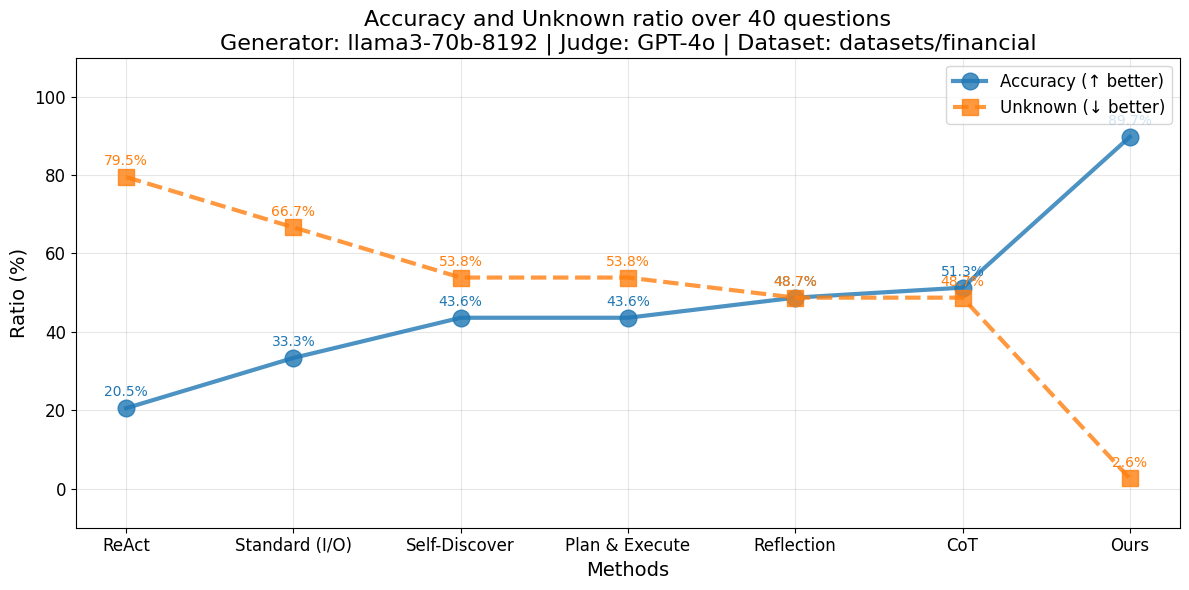

In [98]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple
from cama.utils import evaluate_answers_with_unknowns

# load qa list
qa_list = load_from_json(f'{dataset_folder}/qa_list.json')

def plot_scores_with_unknowns(scores: Dict[str, Tuple[float, float]], llm_name: str):
    """
    Creates a single line plot showing both accuracy scores and unknown ratios.

    Parameters:
    scores (Dict[str, Tuple[float, float]]): A dictionary where keys are method names and values are tuples (accuracy, unknown_ratio).
    llm_name (str): The name of the language model used as the report generator.
    """
    methods = list(scores.keys())
    accuracies = [score[0] for score in scores.values()]
    unknown_ratios = [score[1] for score in scores.values()]

    # Sort methods by accuracy for better visual trend
    sorted_indices = sorted(range(len(accuracies)), key=lambda k: accuracies[k])
    methods = [methods[i] for i in sorted_indices]
    accuracies = [accuracies[i] for i in sorted_indices]
    unknown_ratios = [unknown_ratios[i] for i in sorted_indices]

    plt.figure(figsize=(12, 6))

    # Plot both lines on the same graph
    plt.plot(methods, accuracies, marker='o', linewidth=3, color='#1f77b4', markersize=12, label='Accuracy (↑ better)', alpha=0.8)
    plt.plot(methods, unknown_ratios, marker='s', linewidth=3, color='#ff7f0e', markersize=12, label='Unknown (↓ better)', alpha=0.8, linestyle='--')
    
    # Highlight CAMA with different markers
    # cama_index = methods.index("CAMA") if "CAMA" in methods else -1
    # if cama_index != -1:
    #     plt.plot(cama_index, accuracies[cama_index], marker='*', markersize=20, color='#1f77b4', label='CAMA (Acc)', linewidth=0)
    #     plt.plot(cama_index, unknown_ratios[cama_index], marker='P', markersize=20, color='#ff7f0e', label='CAMA (Unk)', linewidth=0)
    
    plt.ylim(-10, 110)
    plt.xlabel('Methods', fontsize=14)
    plt.ylabel('Ratio (%)', fontsize=14)
    plt.title(f'Accuracy and Unknown ratio over 40 questions\nGenerator: {llm_name} | Judge: GPT-4o | Dataset: {dataset_folder}', fontsize=16)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # # Create a custom legend order
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 1]  # Accuracy, Unknown
    # if cama_index != -1:
    #     order.extend([2, 3])  # CAMA (Acc), CAMA (Unk)
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=12)

    # Add value labels on each point with offset for better readability
    for i, (acc, unk) in enumerate(zip(accuracies, unknown_ratios)):
        # if acc > unk:
        plt.text(i, acc + 3, f'{acc:.1f}%', ha='center', fontsize=10, color='#1f77b4')
        plt.text(i, unk + 3, f'{unk:.1f}%', ha='center', fontsize=10, color='#ff7f0e')
        # else:
        #     plt.text(i, acc - 2, f'{acc:.1f}%', ha='center', fontsize=10, color='#1f77b4')
        #     plt.text(i, unk + 2, f'{unk:.1f}%', ha='center', fontsize=10, color='#ff7f0e')

    # save plot in pdf
    # plt.savefig(f'{dataset_folder}/scores_plot_{llm_name}.pdf', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# Example usage:
scores = {
    "Standard (I/O)": evaluate_answers_with_unknowns(qa_list, answers_full_prompt),
    "CoT": evaluate_answers_with_unknowns(qa_list, answers_full_prompt_cot),
    "Ours": evaluate_answers_with_unknowns(qa_list, answers_cama_agent),
    "Reflection": evaluate_answers_with_unknowns(qa_list, answers_reflection),
    "ReAct": evaluate_answers_with_unknowns(qa_list, answers_react),
    "Self-Discover": evaluate_answers_with_unknowns(qa_list, answers_self_discover),
    "Plan & Execute": evaluate_answers_with_unknowns(qa_list, answers_plan_and_execute),
}

plot_scores_with_unknowns(scores, llm_name)